# Telemetry Data for CI Clusters

Every cluster running an OpenShift CI job sends some operational data back to Red Hat via [Telemetry](https://docs.openshift.com/container-platform/4.7/support/remote_health_monitoring/about-remote-health-monitoring.html#telemetry-about-telemetry_about-remote-health-monitoring). This data gets stored as [Prometheus](https://prometheus.io/docs/introduction/overview/) metrics in a [Thanos](https://github.com/thanos-io/thanos) deployment at Red Hat. Some examples of the prometheus metrics collected here include CPU and memory capacity, operators installed, alerts fired, provider platform, etc. Thus, in addition to high level test run data on testgrid and prow, we also have detailed time series data available for the CI clusters that ran the tests.

In this notebook, we will show how to access this telemetry data using some open source tools developed by the AIOps team. Specifically we will show that, given a specific CI job run, how to get the telemetry data associated with the cluster that ran it.

**NOTE:** Since this data is currently hosted on a Red Hat internal Thanos, only those users with access to it will be able to run this notebook to get "live" data. To ensure that the wider open source community is also able to use this data for further analysis, we will use this notebook to extract a snippet of this data and save it on our public GitHub repo.

In [34]:
# import all the required libraries
import os
import warnings
import datetime as dt
from tqdm.notebook import tqdm
from IPython.display import display
from dotenv import load_dotenv, find_dotenv
from urllib3.exceptions import InsecureRequestWarning

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from prometheus_api_client import (
    PrometheusConnect,
    MetricSnapshotDataFrame,
    MetricRangeDataFrame,
)

import sys

sys.path.insert(1, "../TestGrid/metrics")
from ipynb.fs.defs.metric_template import save_to_disk  # noqa: E402

load_dotenv(find_dotenv())

True

In [2]:
# config for a pretty notebook
sns.set()
load_dotenv(find_dotenv())
warnings.filterwarnings("ignore", category=InsecureRequestWarning)

## Data Access Setup

In this section, we will configure the [prometheus-api-client-python](https://github.com/AICoE/prometheus-api-client-python) tool to pull data from our Thanos instance. That is, set the value of `PROM_URL` to the Thanos endpoint, and set the value of `PROM_ACCESS_TOKEN` to the bearer token for authentication. We will also set the timestamp from which telemetry data is to be pulled.

In order to get access to the token, you can follow either one of these steps:
1. Visit `https://datahub.psi.redhat.com/`. Click on your profile (top right) and select Copy Login Command from the drop down menu. This will copy a command that will look something like: `oc login https://datahub.psi.redhat.com:443 --token=<YOUR_TOKEN>`. The value in YOUR_TOKEN is the required token.
2. From the command line, run `oc whoami --show-token`. Ensure that the output of `oc project` is `https://datahub.psi.redhat.com/`. This will output the required token.

**NOTE:** The above methods can only used if you are on Red Hat VPN.

In [3]:
# prometheus from which metrics are to be fetched
PROM_URL = os.getenv("PROM_URL")
PROM_ACCESS_TOKEN = os.getenv("PROM_ACCESS_TOKEN")

In [4]:
# prometheus connector object
pc = PrometheusConnect(
    url=PROM_URL,
    disable_ssl=True,
    headers={"Authorization": f"bearer {PROM_ACCESS_TOKEN}"},
)

In [5]:
# timestamp for which prometheus queries will be evaluated
query_eval_time = dt.datetime.now(tz=dt.timezone.utc) - dt.timedelta(hours=6)
query_eval_ts = query_eval_time.timestamp()

In [6]:
# which metrics to fetch
# we will try to get all metrics, but leave out ones that may have potentially sensitive data
metrics_to_fetch = [
    m
    for m in pc.all_metrics()
    if "subscription" not in m and "internal" not in m and "url" not in m
]

In [7]:
# these fields are either irrelevant or contain something that could potentially be sensitive
# either way, these likely wont be useful for analysis anyway so exclude them when reading data
drop_cols = [
    "prometheus",
    "tenant_id",
    "endpoint",
    "instance",
    "receive",
    "url",
]

## Get All Data for a Given Job Build

In this section, we will get all the prometheus metrics corresponding to a given job name and build id. The job name and build id can be obtained either directly from the testgrid UI, or from the `query` and `changelists` fields respectively in the testgrid json as shown in the [testgrid metadata EDA notebook](../TestGrid/testgrid_metadata_EDA.ipynb).

One of the metrics stored in Thanos is `cluster_installer`. This metric describes what entity triggered the install of each cluster. For the clusters that run OpenShift CI jobs, the `invoker` label value in this metric is set to `openshift-internal-ci/{job_name}/{build_id}`.

Therefore, we can get all data for a given job build by first finding the ID of the cluster that ran it (using `cluster_installer`), and then querying prometheus for metrics where the `_id` label value equals this cluster ID. These steps are demonstrated through the example below.

In [8]:
# example job and build
job_name = "periodic-ci-openshift-release-master-ci-4.7-upgrade-from-stable-4.6-e2e-aws-ovn-upgrade"
build_id = "1380452039472975872"

In [9]:
# get installer info for the job/build
job_build_cluster_installer = pc.custom_query(
    query=f'cluster_installer{{invoker="openshift-internal-ci/{job_name}/{build_id}"}}',
    params={"time": query_eval_ts},
)

# extract cluster id out of the installer info metric
cluster_id = job_build_cluster_installer[0]["metric"]["_id"]

### Get One Metric

Before we fetch all the metrics, let's fetch just one metric and familiarize ourselves with the data format, and understand how to interpret it. In the cell below, we will look at an example metric, `cluster:cpu_capacity:sum`.

In [10]:
# fetch the metric and format it into a df
metric_df = MetricSnapshotDataFrame(
    pc.custom_query(
        query=f'cluster:capacity_cpu_cores:sum{{_id="{cluster_id}"}}',
        params={"time": query_eval_ts},
    )
)

# drop irrelavant data
metric_df.drop(columns=drop_cols, errors="ignore", inplace=True)

metric_df

__name__                                   _id  \
0  cluster:capacity_cpu_cores:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   
1  cluster:capacity_cpu_cores:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   

  label_beta_kubernetes_io_instance_type label_kubernetes_io_arch  \
0                              m4.xlarge                    amd64   
1                              m5.xlarge                    amd64   

  label_node_openshift_io_os_id     timestamp value  \
0                         rhcos  1.617966e+09    12   
1                         rhcos  1.617966e+09    12   

  label_node_role_kubernetes_io  
0                           NaN  
1                        master

**HOW TO READ THIS DATAFRAME**

In the above dataframe, each column represents a "label" of the prometheus metric, and each row represents a different "label configuration". In this example, the first row has `label_node_role_kubernetes_io` = `NaN` and `value` = `12`, and the second row has `label_node_role_kubernetes_io` = `master` and `value` = `12`. This means that in this cluster, the `master` node had 12 CPU cores, and the `worker` node also had 12 CPU cores.

To learn more about labels, label configurations, and the prometheus data model in general, please check out their official documentation [here](https://prometheus.io/docs/concepts/data_model/).

### Get All Metrics

Now that we understand the data structure of the metrics, let's fetch all the metrics and concatenate them into one single dataframe.

In [11]:
# let's combine all the metrics into one dataframe
# for the above mentioned job name and build name.
all_metrics_df = pd.DataFrame()
for metric in metrics_to_fetch:

    # fetch metric for the cluster
    metric_df = MetricSnapshotDataFrame(
        pc.custom_query(
            query=f'{metric}{{_id="{cluster_id}"}}',
            params={"time": query_eval_ts},
        )
    )

    if len(metric_df) > 0:
        # drop irrelevant cols, if any
        metric_df.drop(columns=drop_cols, errors="ignore", inplace=True)

        # show a glimpse of data
        print(f"Metric = {metric}")
        display(metric_df.head())

        # combine all the metrics data.
        all_metrics_df = pd.concat(
            [
                all_metrics_df,
                metric_df,
            ],
            axis=0,
            join="outer",
            ignore_index=True,
        )

Metric = alerts


__name__                                   _id  \
0   alerts  a4c5e284-11dd-4b9c-af67-a4776665f9df   
1   alerts  a4c5e284-11dd-4b9c-af67-a4776665f9df   

                            alertname alertstate severity     timestamp value  
0  AlertmanagerReceiversNotConfigured     firing  warning  1.617966e+09     1  
1                            Watchdog     firing     none  1.617966e+09     1

Metric = cco_credentials_mode


__name__                                   _id  \
0  cco_credentials_mode  a4c5e284-11dd-4b9c-af67-a4776665f9df   

         container          job  mode                            namespace  \
0  kube-rbac-proxy  cco-metrics  mint  openshift-cloud-credential-operator   

                                          pod      service     timestamp value  
0  cloud-credential-operator-578dd486f4-mnb2j  cco-metrics  1.617966e+09     1

Metric = cluster:apiserver_current_inflight_requests:sum:max_over_time:2m


__name__  \
0  cluster:apiserver_current_inflight_requests:su...   
1  cluster:apiserver_current_inflight_requests:su...   

                                    _id            apiserver     timestamp  \
0  a4c5e284-11dd-4b9c-af67-a4776665f9df       kube-apiserver  1.617966e+09   
1  a4c5e284-11dd-4b9c-af67-a4776665f9df  openshift-apiserver  1.617966e+09   

  value  
0    18  
1     3

Metric = cluster:capacity_cpu_cores:sum


__name__                                   _id  \
0  cluster:capacity_cpu_cores:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   
1  cluster:capacity_cpu_cores:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   

  label_beta_kubernetes_io_instance_type label_kubernetes_io_arch  \
0                              m4.xlarge                    amd64   
1                              m5.xlarge                    amd64   

  label_node_openshift_io_os_id     timestamp value  \
0                         rhcos  1.617966e+09    12   
1                         rhcos  1.617966e+09    12   

  label_node_role_kubernetes_io  
0                           NaN  
1                        master

Metric = cluster:capacity_memory_bytes:sum


__name__                                   _id  \
0  cluster:capacity_memory_bytes:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   
1  cluster:capacity_memory_bytes:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   

  label_beta_kubernetes_io_instance_type     timestamp        value  \
0                              m4.xlarge  1.617966e+09  50432839680   
1                              m5.xlarge  1.617966e+09  49156497408   

  label_node_role_kubernetes_io  
0                           NaN  
1                        master

Metric = cluster:cpu_usage_cores:sum


__name__                                   _id  \
0  cluster:cpu_usage_cores:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   

      timestamp              value  
0  1.617966e+09  8.916476190476182

Metric = cluster:kube_persistentvolume_plugin_type_counts:sum


__name__  \
0  cluster:kube_persistentvolume_plugin_type_coun...   

                                    _id            plugin_name volume_mode  \
0  a4c5e284-11dd-4b9c-af67-a4776665f9df  kubernetes.io/aws-ebs  Filesystem   

      timestamp value  
0  1.617966e+09     2

Metric = cluster:kube_persistentvolumeclaim_resource_requests_storage_bytes:provisioner:sum


__name__  \
0  cluster:kube_persistentvolumeclaim_resource_re...   

                                    _id            provisioner     timestamp  \
0  a4c5e284-11dd-4b9c-af67-a4776665f9df  kubernetes.io/aws-ebs  1.617966e+09   

         value  
0  21474836480

Metric = cluster:kubelet_volume_stats_used_bytes:provisioner:sum


__name__  \
0  cluster:kubelet_volume_stats_used_bytes:provis...   

                                    _id            provisioner     timestamp  \
0  a4c5e284-11dd-4b9c-af67-a4776665f9df  kubernetes.io/aws-ebs  1.617966e+09   

       value  
0  525832192

Metric = cluster:memory_usage_bytes:sum


__name__                                   _id  \
0  cluster:memory_usage_bytes:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   

      timestamp        value  
0  1.617966e+09  35710898176

Metric = cluster:network_attachment_definition_enabled_instance_up:max


__name__  \
0  cluster:network_attachment_definition_enabled_...   
1  cluster:network_attachment_definition_enabled_...   
2  cluster:network_attachment_definition_enabled_...   

                                    _id  networks     timestamp value  
0  a4c5e284-11dd-4b9c-af67-a4776665f9df       any  1.617966e+09     0  
1  a4c5e284-11dd-4b9c-af67-a4776665f9df  ib-sriov  1.617966e+09     0  
2  a4c5e284-11dd-4b9c-af67-a4776665f9df     sriov  1.617966e+09     0

Metric = cluster:network_attachment_definition_instances:max


__name__  \
0  cluster:network_attachment_definition_instance...   
1  cluster:network_attachment_definition_instance...   
2  cluster:network_attachment_definition_instance...   

                                    _id  networks     timestamp value  
0  a4c5e284-11dd-4b9c-af67-a4776665f9df       any  1.617966e+09     0  
1  a4c5e284-11dd-4b9c-af67-a4776665f9df  ib-sriov  1.617966e+09     0  
2  a4c5e284-11dd-4b9c-af67-a4776665f9df     sriov  1.617966e+09     0

Metric = cluster:node_instance_type_count:sum


__name__                                   _id  \
0  cluster:node_instance_type_count:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   
1  cluster:node_instance_type_count:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   

  label_beta_kubernetes_io_instance_type label_kubernetes_io_arch  \
0                              m4.xlarge                    amd64   
1                              m5.xlarge                    amd64   

  label_node_openshift_io_os_id     timestamp value  \
0                         rhcos  1.617966e+09     6   
1                         rhcos  1.617966e+09     3   

  label_node_role_kubernetes_io  
0                           NaN  
1                        master

Metric = cluster:telemetry_selected_series:count


__name__  \
0  cluster:telemetry_selected_series:count   

                                    _id     timestamp value  
0  a4c5e284-11dd-4b9c-af67-a4776665f9df  1.617966e+09   453

Metric = cluster:usage:containers:sum


__name__                                   _id  \
0  cluster:usage:containers:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   

      timestamp value  
0  1.617966e+09  1027

Metric = cluster:usage:ingress_frontend_bytes_in:rate5m:sum


__name__  \
0  cluster:usage:ingress_frontend_bytes_in:rate5m...   

                                    _id     timestamp              value  
0  a4c5e284-11dd-4b9c-af67-a4776665f9df  1.617966e+09  2589.339455740741

Metric = cluster:usage:ingress_frontend_bytes_out:rate5m:sum


__name__  \
0  cluster:usage:ingress_frontend_bytes_out:rate5...   

                                    _id     timestamp               value  
0  a4c5e284-11dd-4b9c-af67-a4776665f9df  1.617966e+09  21394.726972761906

Metric = cluster:usage:ingress_frontend_connections:sum


__name__  \
0  cluster:usage:ingress_frontend_connections:sum   

                                    _id     timestamp value  
0  a4c5e284-11dd-4b9c-af67-a4776665f9df  1.617966e+09     4

Metric = cluster:usage:kube_node_ready:avg5m


__name__                                   _id  \
0  cluster:usage:kube_node_ready:avg5m  a4c5e284-11dd-4b9c-af67-a4776665f9df   

      timestamp value  
0  1.617966e+09     1

Metric = cluster:usage:kube_schedulable_node_ready_reachable:avg5m


__name__  \
0  cluster:usage:kube_schedulable_node_ready_reac...   

                                    _id     timestamp value  
0  a4c5e284-11dd-4b9c-af67-a4776665f9df  1.617966e+09     1

Metric = cluster:usage:openshift:ingress_request_error:fraction5m


__name__  \
0  cluster:usage:openshift:ingress_request_error:...   

                                    _id     timestamp value  
0  a4c5e284-11dd-4b9c-af67-a4776665f9df  1.617966e+09     0

Metric = cluster:usage:openshift:ingress_request_total:irate5m


__name__  \
0  cluster:usage:openshift:ingress_request_total:...   

                                    _id     timestamp              value  
0  a4c5e284-11dd-4b9c-af67-a4776665f9df  1.617966e+09  3.633333333333333

Metric = cluster:usage:openshift:kube_running_pod_ready:avg


__name__  \
0  cluster:usage:openshift:kube_running_pod_ready...   

                                    _id     timestamp               value  
0  a4c5e284-11dd-4b9c-af67-a4776665f9df  1.617966e+09  0.9764150943396227

Metric = cluster:usage:pods:terminal:workload:sum


__name__  \
0  cluster:usage:pods:terminal:workload:sum   

                                    _id     timestamp value  
0  a4c5e284-11dd-4b9c-af67-a4776665f9df  1.617966e+09     3

Metric = cluster:usage:resources:sum


__name__                                   _id  \
0  cluster:usage:resources:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   
1  cluster:usage:resources:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   
2  cluster:usage:resources:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   
3  cluster:usage:resources:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   
4  cluster:usage:resources:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   

                                    resource     timestamp value  
0  alertmanagerconfigs.monitoring.coreos.com  1.617966e+09     0  
1        alertmanagers.monitoring.coreos.com  1.617966e+09     1  
2             apiservers.config.openshift.io  1.617966e+09     1  
3         apiservices.apiregistration.k8s.io  1.617966e+09    79  
4        authentications.config.openshift.io  1.617966e+09     1

Metric = cluster:usage:workload:capacity_physical_cpu_core_seconds


__name__  \
0  cluster:usage:workload:capacity_physical_cpu_c...   

                                    _id     timestamp value  
0  a4c5e284-11dd-4b9c-af67-a4776665f9df  1.617966e+09  5742

Metric = cluster:usage:workload:capacity_physical_cpu_cores:max:5m


__name__  \
0  cluster:usage:workload:capacity_physical_cpu_c...   

                                    _id     timestamp value  
0  a4c5e284-11dd-4b9c-af67-a4776665f9df  1.617966e+09     6

Metric = cluster:usage:workload:capacity_physical_cpu_cores:min:5m


__name__  \
0  cluster:usage:workload:capacity_physical_cpu_c...   

                                    _id     timestamp value  
0  a4c5e284-11dd-4b9c-af67-a4776665f9df  1.617966e+09     6

Metric = cluster:usage:workload:ingress_request_error:fraction5m


__name__  \
0  cluster:usage:workload:ingress_request_error:f...   

                                    _id     timestamp value  
0  a4c5e284-11dd-4b9c-af67-a4776665f9df  1.617966e+09     0

Metric = cluster:usage:workload:ingress_request_total:irate5m


__name__  \
0  cluster:usage:workload:ingress_request_total:i...   

                                    _id     timestamp value  
0  a4c5e284-11dd-4b9c-af67-a4776665f9df  1.617966e+09     0

Metric = cluster:usage:workload:kube_running_pod_ready:avg


__name__  \
0  cluster:usage:workload:kube_running_pod_ready:avg   

                                    _id     timestamp value  
0  a4c5e284-11dd-4b9c-af67-a4776665f9df  1.617966e+09     1

Metric = cluster:virt_platform_nodes:sum


__name__                                   _id  \
0  cluster:virt_platform_nodes:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   
1  cluster:virt_platform_nodes:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   
2  cluster:virt_platform_nodes:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   
3  cluster:virt_platform_nodes:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   

      type     timestamp value  
0      aws  1.617966e+09     6  
1      kvm  1.617966e+09     3  
2      xen  1.617966e+09     3  
3  xen-hvm  1.617966e+09     3

Metric = cluster_feature_set


__name__                                   _id  \
0  cluster_feature_set  a4c5e284-11dd-4b9c-af67-a4776665f9df   

                 container      job                          namespace  \
0  kube-apiserver-operator  metrics  openshift-kube-apiserver-operator   

                                       pod  service     timestamp value  
0  kube-apiserver-operator-568c9bd46-vc2m6  metrics  1.617966e+09     1

Metric = cluster_infrastructure_provider


__name__                                   _id  \
0  cluster_infrastructure_provider  a4c5e284-11dd-4b9c-af67-a4776665f9df   

                 container      job                          namespace  \
0  kube-apiserver-operator  metrics  openshift-kube-apiserver-operator   

                                       pod     region  service type  \
0  kube-apiserver-operator-568c9bd46-vc2m6  us-east-1  metrics  AWS   

      timestamp value  
0  1.617966e+09     1

Metric = cluster_installer


__name__                                   _id  \
0  cluster_installer  a4c5e284-11dd-4b9c-af67-a4776665f9df   

                                             invoker  \
0  openshift-internal-ci/periodic-ci-openshift-re...   

                        job                  namespace  \
0  cluster-version-operator  openshift-cluster-version   

                                         pod                   service  \
0  cluster-version-operator-7f6578f6df-9zkr2  cluster-version-operator   

                type version     timestamp value  
0  openshift-install  v4.6.0  1.617966e+09     1

Metric = cluster_legacy_scheduler_policy


__name__                                   _id  \
0  cluster_legacy_scheduler_policy  a4c5e284-11dd-4b9c-af67-a4776665f9df   

       job                          namespace  \
0  metrics  openshift-kube-scheduler-operator   

                                                 pod  service     timestamp  \
0  openshift-kube-scheduler-operator-69d8d7c996-g...  metrics  1.617966e+09   

  value  
0     0

Metric = cluster_master_schedulable


__name__                                   _id      job  \
0  cluster_master_schedulable  a4c5e284-11dd-4b9c-af67-a4776665f9df  metrics   

                           namespace  \
0  openshift-kube-scheduler-operator   

                                                 pod  service     timestamp  \
0  openshift-kube-scheduler-operator-69d8d7c996-g...  metrics  1.617966e+09   

  value  
0     0

Metric = cluster_operator_conditions


__name__                                   _id  \
0  cluster_operator_conditions  a4c5e284-11dd-4b9c-af67-a4776665f9df   
1  cluster_operator_conditions  a4c5e284-11dd-4b9c-af67-a4776665f9df   
2  cluster_operator_conditions  a4c5e284-11dd-4b9c-af67-a4776665f9df   
3  cluster_operator_conditions  a4c5e284-11dd-4b9c-af67-a4776665f9df   
4  cluster_operator_conditions  a4c5e284-11dd-4b9c-af67-a4776665f9df   

   condition                       job                name  \
0  Available  cluster-version-operator      authentication   
1  Available  cluster-version-operator           baremetal   
2  Available  cluster-version-operator    cloud-credential   
3  Available  cluster-version-operator  cluster-autoscaler   
4  Available  cluster-version-operator     config-operator   

                   namespace                                        pod  \
0  openshift-cluster-version  cluster-version-operator-7f6578f6df-9zkr2   
1  openshift-cluster-version  cluster-version-operator-7f6578f6df-9zkr2   
2  openshift-cluster-version  cluster-version-operator-7f6578f6df-9zkr2   
3  openshift-cluster-version  cluster-version-operator-7f6578f6df-9zkr2   
4  openshift-cluster-version  cluster-version-operator-7f6578f6df-9zkr2   

       reason                   service     timestamp value  
0  AsExpected  cluster-version-operator  1.617966e+09     1  
1  AsExpected  cluster-version-operator  1.617966e+09     1  
2         NaN  cluster-version-operator  1.617966e+09     1  
3  AsExpected  cluster-version-operator  1.617966e+09     1  
4  AsExpected  cluster-version-operator  1.617966e+09     1

Metric = cluster_operator_up


__name__                                   _id  \
0  cluster_operator_up  a4c5e284-11dd-4b9c-af67-a4776665f9df   
1  cluster_operator_up  a4c5e284-11dd-4b9c-af67-a4776665f9df   
2  cluster_operator_up  a4c5e284-11dd-4b9c-af67-a4776665f9df   
3  cluster_operator_up  a4c5e284-11dd-4b9c-af67-a4776665f9df   
4  cluster_operator_up  a4c5e284-11dd-4b9c-af67-a4776665f9df   

                        job                name                  namespace  \
0  cluster-version-operator      authentication  openshift-cluster-version   
1  cluster-version-operator           baremetal  openshift-cluster-version   
2  cluster-version-operator    cloud-credential  openshift-cluster-version   
3  cluster-version-operator  cluster-autoscaler  openshift-cluster-version   
4  cluster-version-operator     config-operator  openshift-cluster-version   

                                         pod                   service  \
0  cluster-version-operator-7f6578f6df-9zkr2  cluster-version-operator   
1  cluster-version-operator-7f6578f6df-9zkr2  cluster-version-operator   
2  cluster-version-operator-7f6578f6df-9zkr2  cluster-version-operator   
3  cluster-version-operator-7f6578f6df-9zkr2  cluster-version-operator   
4  cluster-version-operator-7f6578f6df-9zkr2  cluster-version-operator   

                        version     timestamp value  
0  4.7.0-0.ci-2021-04-07-120112  1.617966e+09     1  
1  4.7.0-0.ci-2021-04-07-120112  1.617966e+09     1  
2  4.7.0-0.ci-2021-04-07-120112  1.617966e+09     1  
3  4.7.0-0.ci-2021-04-07-120112  1.617966e+09     1  
4  4.7.0-0.ci-2021-04-07-120112  1.617966e+09     1

Metric = cluster_version


__name__                                   _id from_version  \
0  cluster_version  a4c5e284-11dd-4b9c-af67-a4776665f9df       4.6.23   
1  cluster_version  a4c5e284-11dd-4b9c-af67-a4776665f9df       4.6.23   
2  cluster_version  a4c5e284-11dd-4b9c-af67-a4776665f9df       4.6.23   
3  cluster_version  a4c5e284-11dd-4b9c-af67-a4776665f9df          NaN   
4  cluster_version  a4c5e284-11dd-4b9c-af67-a4776665f9df          NaN   

                                               image  \
0  registry.build02.ci.openshift.org/ci-op-lnd3sj...   
1  registry.build02.ci.openshift.org/ci-op-lnd3sj...   
2  registry.build02.ci.openshift.org/ci-op-lnd3sj...   
3  registry.build02.ci.openshift.org/ci-op-lnd3sj...   
4  registry.build02.ci.openshift.org/ci-op-lnd3sj...   

                        job                  namespace  \
0  cluster-version-operator  openshift-cluster-version   
1  cluster-version-operator  openshift-cluster-version   
2  cluster-version-operator  openshift-cluster-version   
3  cluster-version-operator  openshift-cluster-version   
4  cluster-version-operator  openshift-cluster-version   

                                         pod                   service  \
0  cluster-version-operator-7f6578f6df-9zkr2  cluster-version-operator   
1  cluster-version-operator-7f6578f6df-9zkr2  cluster-version-operator   
2  cluster-version-operator-7f6578f6df-9zkr2  cluster-version-operator   
3  cluster-version-operator-7f6578f6df-9zkr2  cluster-version-operator   
4  cluster-version-operator-7f6578f6df-9zkr2  cluster-version-operator   

        type                       version     timestamp       value  
0    cluster  4.7.0-0.ci-2021-04-07-120112  1.617966e+09  1617960923  
1    current  4.7.0-0.ci-2021-04-07-120112  1.617966e+09  1617797321  
2   updating  4.7.0-0.ci-2021-04-07-120112  1.617966e+09  1617963108  
3  completed                        4.6.23  1.617966e+09  1617962883  
4    initial                        4.6.23  1.617966e+09  1617960923

Metric = cluster_version_available_updates


__name__                                   _id  \
0  cluster_version_available_updates  a4c5e284-11dd-4b9c-af67-a4776665f9df   

                        job                  namespace  \
0  cluster-version-operator  openshift-cluster-version   

                                         pod                   service  \
0  cluster-version-operator-7f6578f6df-9zkr2  cluster-version-operator   

                                            upstream     timestamp value  
0  https://api.openshift.com/api/upgrades_info/v1...  1.617966e+09     0

Metric = cluster_version_payload


__name__                                   _id  \
0  cluster_version_payload  a4c5e284-11dd-4b9c-af67-a4776665f9df   
1  cluster_version_payload  a4c5e284-11dd-4b9c-af67-a4776665f9df   

                        job                  namespace  \
0  cluster-version-operator  openshift-cluster-version   
1  cluster-version-operator  openshift-cluster-version   

                                         pod                   service  \
0  cluster-version-operator-7f6578f6df-9zkr2  cluster-version-operator   
1  cluster-version-operator-7f6578f6df-9zkr2  cluster-version-operator   

      type                       version     timestamp value  
0  applied  4.7.0-0.ci-2021-04-07-120112  1.617966e+09   403  
1  pending  4.7.0-0.ci-2021-04-07-120112  1.617966e+09   265

Metric = code:apiserver_request_total:rate:sum


__name__  \
0  code:apiserver_request_total:rate:sum   
1  code:apiserver_request_total:rate:sum   
2  code:apiserver_request_total:rate:sum   
3  code:apiserver_request_total:rate:sum   
4  code:apiserver_request_total:rate:sum   

                                    _id code     timestamp               value  
0  a4c5e284-11dd-4b9c-af67-a4776665f9df    0  1.617966e+09  17.963446730217427  
1  a4c5e284-11dd-4b9c-af67-a4776665f9df  200  1.617966e+09   88.57392683079763  
2  a4c5e284-11dd-4b9c-af67-a4776665f9df  201  1.617966e+09     9.1977697122807  
3  a4c5e284-11dd-4b9c-af67-a4776665f9df  400  1.617966e+09                   0  
4  a4c5e284-11dd-4b9c-af67-a4776665f9df  404  1.617966e+09  12.106612631578946

Metric = count:up0


__name__                                   _id        container  \
0  count:up0  a4c5e284-11dd-4b9c-af67-a4776665f9df  kube-rbac-proxy   

                    job              namespace               service  \
0  machine-api-operator  openshift-machine-api  machine-api-operator   

      timestamp value  
0  1.617966e+09     1

Metric = count:up1


__name__                                   _id            apiserver  \
0  count:up1  a4c5e284-11dd-4b9c-af67-a4776665f9df       kube-apiserver   
1  count:up1  a4c5e284-11dd-4b9c-af67-a4776665f9df  openshift-apiserver   
2  count:up1  a4c5e284-11dd-4b9c-af67-a4776665f9df                  NaN   
3  count:up1  a4c5e284-11dd-4b9c-af67-a4776665f9df                  NaN   
4  count:up1  a4c5e284-11dd-4b9c-af67-a4776665f9df                  NaN   

                        job                             namespace  \
0                 apiserver                               default   
1                       api                   openshift-apiserver   
2         alertmanager-main                  openshift-monitoring   
3  catalog-operator-metrics  openshift-operator-lifecycle-manager   
4   image-registry-operator              openshift-image-registry   

                    service     timestamp value  \
0                kubernetes  1.617966e+09     3   
1                       api  1.617966e+09     2   
2         alertmanager-main  1.617966e+09     3   
3  catalog-operator-metrics  1.617966e+09     1   
4   image-registry-operator  1.617966e+09     2   

                         container metrics_path  
0                              NaN          NaN  
1              openshift-apiserver          NaN  
2               alertmanager-proxy          NaN  
3                 catalog-operator          NaN  
4  cluster-image-registry-operator          NaN

Metric = csv_succeeded


__name__                                   _id     container  \
0  csv_succeeded  a4c5e284-11dd-4b9c-af67-a4776665f9df  olm-operator   

                     exported_namespace                   job           name  \
0  openshift-operator-lifecycle-manager  olm-operator-metrics  packageserver   

                              namespace                            pod  \
0  openshift-operator-lifecycle-manager  olm-operator-675c8c5455-vljrp   

                service version     timestamp value  
0  olm-operator-metrics  0.17.0  1.617966e+09     1

Metric = id_install_type


__name__                                   _id install_type  \
0  id_install_type  a4c5e284-11dd-4b9c-af67-a4776665f9df          ipi   

      timestamp value  
0  1.617966e+09     0

Metric = id_primary_host_type


__name__                                   _id host_type  \
0  id_primary_host_type  a4c5e284-11dd-4b9c-af67-a4776665f9df       aws   

      timestamp value  
0  1.617966e+09     0

Metric = id_provider


__name__                                   _id provider     timestamp  \
0  id_provider  a4c5e284-11dd-4b9c-af67-a4776665f9df      AWS  1.617966e+09   

  value  
0     0

Metric = id_version


__name__                                   _id  \
0  id_version  a4c5e284-11dd-4b9c-af67-a4776665f9df   

                        version     timestamp value  
0  4.7.0-0.ci-2021-04-07-120112  1.617966e+09     0

Metric = id_version:cluster_available


__name__                                   _id  \
0  id_version:cluster_available  a4c5e284-11dd-4b9c-af67-a4776665f9df   

                        version     timestamp value  
0  4.7.0-0.ci-2021-04-07-120112  1.617966e+09     1

Metric = instance:etcd_object_counts:sum


__name__                                   _id  \
0  instance:etcd_object_counts:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   
1  instance:etcd_object_counts:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   
2  instance:etcd_object_counts:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   
3  instance:etcd_object_counts:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   
4  instance:etcd_object_counts:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   

      timestamp  value  
0  1.617966e+09  13347  
1  1.617966e+09  13226  
2  1.617966e+09  13222  
3  1.617966e+09    535  
4  1.617966e+09    535

Metric = monitoring:container_memory_working_set_bytes:sum


__name__  \
0  monitoring:container_memory_working_set_bytes:sum   

                                    _id             namespace     timestamp  \
0  a4c5e284-11dd-4b9c-af67-a4776665f9df  openshift-monitoring  1.617966e+09   

        value  
0  7885987840

Metric = monitoring:haproxy_server_http_responses_total:sum


__name__  \
0  monitoring:haproxy_server_http_responses_total...   
1  monitoring:haproxy_server_http_responses_total...   
2  monitoring:haproxy_server_http_responses_total...   

                                    _id   exported_service     timestamp value  
0  a4c5e284-11dd-4b9c-af67-a4776665f9df  alertmanager-main  1.617966e+09     0  
1  a4c5e284-11dd-4b9c-af67-a4776665f9df            grafana  1.617966e+09     0  
2  a4c5e284-11dd-4b9c-af67-a4776665f9df     prometheus-k8s  1.617966e+09     0

Metric = node_role_os_version_machine:cpu_capacity_cores:sum


__name__  \
0  node_role_os_version_machine:cpu_capacity_core...   
1  node_role_os_version_machine:cpu_capacity_core...   

                                    _id label_kubernetes_io_arch  \
0  a4c5e284-11dd-4b9c-af67-a4776665f9df                    amd64   
1  a4c5e284-11dd-4b9c-af67-a4776665f9df                    amd64   

  label_node_hyperthread_enabled label_node_openshift_io_os_id  \
0                           true                         rhcos   
1                           true                         rhcos   

  label_node_role_kubernetes_io_master     timestamp value  
0                                 true  1.617966e+09     6  
1                                  NaN  1.617966e+09     6

Metric = node_role_os_version_machine:cpu_capacity_sockets:sum


__name__  \
0  node_role_os_version_machine:cpu_capacity_sock...   
1  node_role_os_version_machine:cpu_capacity_sock...   

                                    _id label_kubernetes_io_arch  \
0  a4c5e284-11dd-4b9c-af67-a4776665f9df                    amd64   
1  a4c5e284-11dd-4b9c-af67-a4776665f9df                    amd64   

  label_node_hyperthread_enabled label_node_openshift_io_os_id  \
0                           true                         rhcos   
1                           true                         rhcos   

  label_node_role_kubernetes_io_master     timestamp value  
0                                 true  1.617966e+09     3  
1                                  NaN  1.617966e+09     3

Metric = openshift:cpu_usage_cores:sum


__name__                                   _id  \
0  openshift:cpu_usage_cores:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   

      timestamp              value  
0  1.617966e+09  8.710434819619936

Metric = openshift:memory_usage_bytes:sum


__name__                                   _id  \
0  openshift:memory_usage_bytes:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   

      timestamp        value  
0  1.617966e+09  34930552832

Metric = openshift:prometheus_tsdb_head_samples_appended_total:sum


__name__  \
0  openshift:prometheus_tsdb_head_samples_appende...   

                                    _id             job             namespace  \
0  a4c5e284-11dd-4b9c-af67-a4776665f9df  prometheus-k8s  openshift-monitoring   

      timestamp               value  
0  1.617966e+09  19098.033333333333

Metric = openshift:prometheus_tsdb_head_series:sum


__name__  \
0  openshift:prometheus_tsdb_head_series:sum   

                                    _id             job             namespace  \
0  a4c5e284-11dd-4b9c-af67-a4776665f9df  prometheus-k8s  openshift-monitoring   

      timestamp    value  
0  1.617966e+09  1133366

Metric = workload:cpu_usage_cores:sum


__name__                                   _id  \
0  workload:cpu_usage_cores:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   

      timestamp                value  
0  1.617966e+09  0.20604137085624644

Metric = workload:memory_usage_bytes:sum


__name__                                   _id  \
0  workload:memory_usage_bytes:sum  a4c5e284-11dd-4b9c-af67-a4776665f9df   

      timestamp      value  
0  1.617966e+09  780345344

In [12]:
# peak into the combined data df
with pd.option_context("display.max_columns", 50):
    display(all_metrics_df.head())

__name__  \
0                                             alerts   
1                                             alerts   
2                               cco_credentials_mode   
3  cluster:apiserver_current_inflight_requests:su...   
4  cluster:apiserver_current_inflight_requests:su...   

                                    _id                           alertname  \
0  a4c5e284-11dd-4b9c-af67-a4776665f9df  AlertmanagerReceiversNotConfigured   
1  a4c5e284-11dd-4b9c-af67-a4776665f9df                            Watchdog   
2  a4c5e284-11dd-4b9c-af67-a4776665f9df                                 NaN   
3  a4c5e284-11dd-4b9c-af67-a4776665f9df                                 NaN   
4  a4c5e284-11dd-4b9c-af67-a4776665f9df                                 NaN   

  alertstate severity     timestamp value        container          job  mode  \
0     firing  warning  1.617966e+09     1              NaN          NaN   NaN   
1     firing     none  1.617966e+09     1              NaN          NaN   NaN   
2        NaN      NaN  1.617966e+09     1  kube-rbac-proxy  cco-metrics  mint   
3        NaN      NaN  1.617966e+09    18              NaN          NaN   NaN   
4        NaN      NaN  1.617966e+09     3              NaN          NaN   NaN   

                             namespace  \
0                                  NaN   
1                                  NaN   
2  openshift-cloud-credential-operator   
3                                  NaN   
4                                  NaN   

                                          pod      service  \
0                                         NaN          NaN   
1                                         NaN          NaN   
2  cloud-credential-operator-578dd486f4-mnb2j  cco-metrics   
3                                         NaN          NaN   
4                                         NaN          NaN   

             apiserver label_beta_kubernetes_io_instance_type  \
0                  NaN                                    NaN   
1                  NaN                                    NaN   
2                  NaN                                    NaN   
3       kube-apiserver                                    NaN   
4  openshift-apiserver                                    NaN   

  label_kubernetes_io_arch label_node_openshift_io_os_id  \
0                      NaN                           NaN   
1                      NaN                           NaN   
2                      NaN                           NaN   
3                      NaN                           NaN   
4                      NaN                           NaN   

  label_node_role_kubernetes_io plugin_name volume_mode provisioner networks  \
0                           NaN         NaN         NaN         NaN      NaN   
1                           NaN         NaN         NaN         NaN      NaN   
2                           NaN         NaN         NaN         NaN      NaN   
3                           NaN         NaN         NaN         NaN      NaN   
4                           NaN         NaN         NaN         NaN      NaN   

  resource type region invoker version condition name reason from_version  \
0      NaN  NaN    NaN     NaN     NaN       NaN  NaN    NaN          NaN   
1      NaN  NaN    NaN     NaN     NaN       NaN  NaN    NaN          NaN   
2      NaN  NaN    NaN     NaN     NaN       NaN  NaN    NaN          NaN   
3      NaN  NaN    NaN     NaN     NaN       NaN  NaN    NaN          NaN   
4      NaN  NaN    NaN     NaN     NaN       NaN  NaN    NaN          NaN   

  image upstream code metrics_path exported_namespace install_type host_type  \
0   NaN      NaN  NaN          NaN                NaN          NaN       NaN   
1   NaN      NaN  NaN          NaN                NaN          NaN       NaN   
2   NaN      NaN  NaN          NaN                NaN          NaN       NaN   
3   NaN      NaN  NaN          NaN                NaN          NaN       NaN   
4   NaN      NaN  NaN  

## Get Data for Multiple Builds for a Given Job

In this section, we will fetch all the telemetry metrics from all timestamps for the top 10 most recent builds for a given job. This data can help understand how the behavior of the available metrics changed over time, across builds.

In [13]:
# fetch data from this number of builds for this job
NBUILDS = 10

# number of previous days of data to search to get the last n builds data for this job
NDAYS = 2

# max runtime of a build
# NOTE: this is a (over)estimate number derived from SME conversations, as well as time duration from testgrid
MAX_DURATION_HRS = 12

In [14]:
# get invoker details
prev_ndays_invokers = MetricRangeDataFrame(
    pc.custom_query_range(
        query=f'max by (_id, invoker) (cluster_installer{{invoker=~"^openshift-internal-ci/{job_name}.*"}})',
        end_time=query_eval_time,
        start_time=query_eval_time - dt.timedelta(days=NDAYS),
        step="5m",
    )
).sort_index()

# split invoker name into prefix, job id, build id.
prev_ndays_invokers[["prefix", "job_name", "build_id"]] = prev_ndays_invokers[
    "invoker"
].str.split("/", expand=True)

# drop now redundant columns.
prev_ndays_invokers.drop(columns=["invoker", "prefix", "value"], inplace=True)

# drop irrelevant columns.
prev_ndays_invokers.drop(columns=drop_cols, errors="ignore", inplace=True)

prev_ndays_invokers.head()

_id  \
timestamp                                          
1617793200  70f9c6f3-eb6e-40e7-8b95-a233bba63e84   
1617793200  141ef74c-98e2-48cd-8364-fb338e3e1e37   
1617793500  70f9c6f3-eb6e-40e7-8b95-a233bba63e84   
1617793500  141ef74c-98e2-48cd-8364-fb338e3e1e37   
1617793800  141ef74c-98e2-48cd-8364-fb338e3e1e37   

                                                     job_name  \
timestamp                                                       
1617793200  periodic-ci-openshift-release-master-ci-4.7-up...   
1617793200  periodic-ci-openshift-release-master-ci-4.7-up...   
1617793500  periodic-ci-openshift-release-master-ci-4.7-up...   
1617793500  periodic-ci-openshift-release-master-ci-4.7-up...   
1617793800  periodic-ci-openshift-release-master-ci-4.7-up...   

                       build_id  
timestamp                        
1617793200  1379730553359568896  
1617793200  1379732995325300736  
1617793500  1379730553359568896  
1617793500  1379732995325300736  
1617793800  1379732995325300736

In [23]:
# for each build, get cluster id and then the corresponding metrics from all timestamps
all_metrics_df = pd.DataFrame()

for build_id in tqdm(prev_ndays_invokers["build_id"].unique()[:NBUILDS]):

    job_build_cluster_installer = pc.custom_query_range(
        query=f'cluster_installer{{invoker="openshift-internal-ci/{job_name}/{build_id}"}}',
        end_time=query_eval_time,
        start_time=query_eval_time
        - dt.timedelta(days=NDAYS)
        - dt.timedelta(days=MAX_DURATION_HRS),
        step="5m",
    )

    # extract cluster id out of the installer info metric
    cluster_id = job_build_cluster_installer[0]["metric"]["_id"]

    # get all telemetry time series
    for metric in metrics_to_fetch:

        # fetch the metric
        metric_result = pc.custom_query_range(
            query=f'{metric}{{_id="{cluster_id}"}}',
            end_time=query_eval_time,
            start_time=query_eval_time
            - dt.timedelta(days=NDAYS)
            - dt.timedelta(days=MAX_DURATION_HRS),
            step="5m",
        )

        if len(metric_result) > 0:
            metric_df = MetricRangeDataFrame(metric_result).reset_index(drop=False)

            # drop irrelevant cols, if any
            metric_df.drop(columns=drop_cols, errors="ignore", inplace=True)

            # combine all the metrics data.
            all_metrics_df = pd.concat(
                [
                    all_metrics_df,
                    metric_df,
                ],
                axis=0,
                join="outer",
                ignore_index=True,
            )

all_metrics_df["value"] = all_metrics_df["value"].astype(float)

  0%|          | 0/10 [00:00<?, ?it/s]

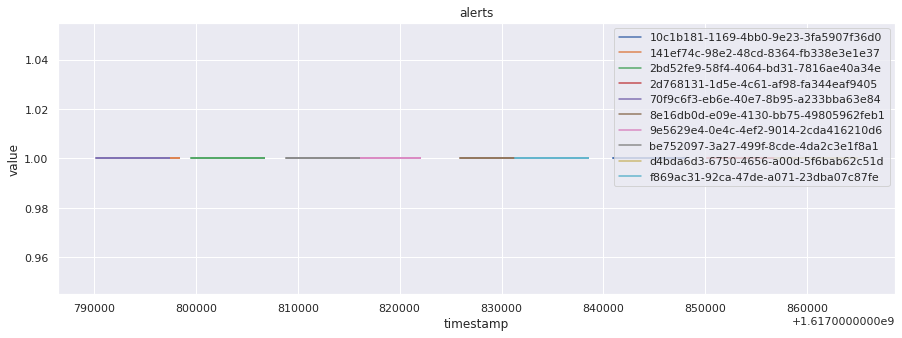

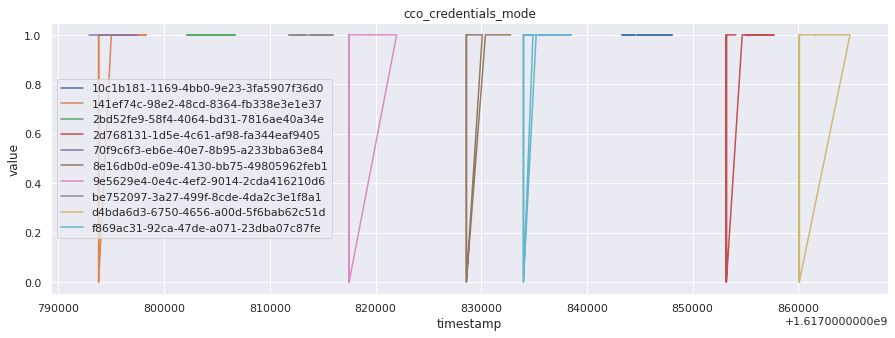

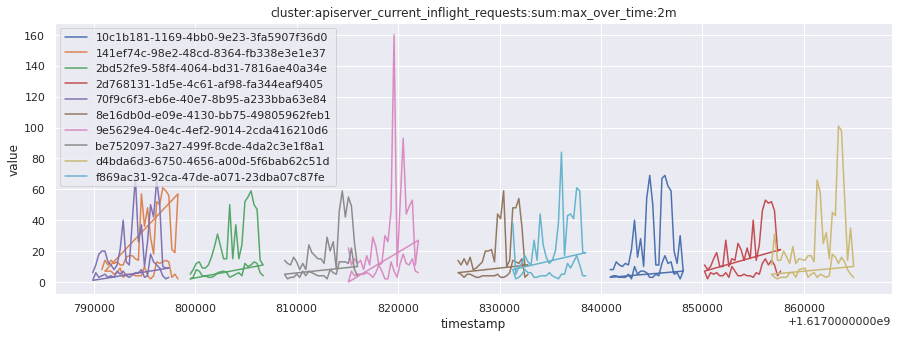

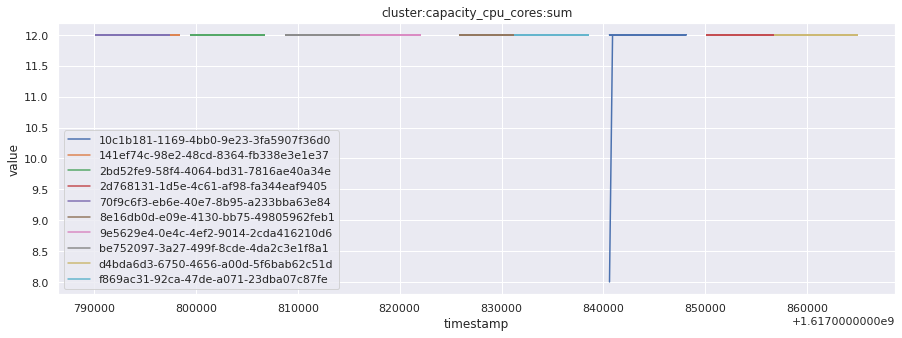

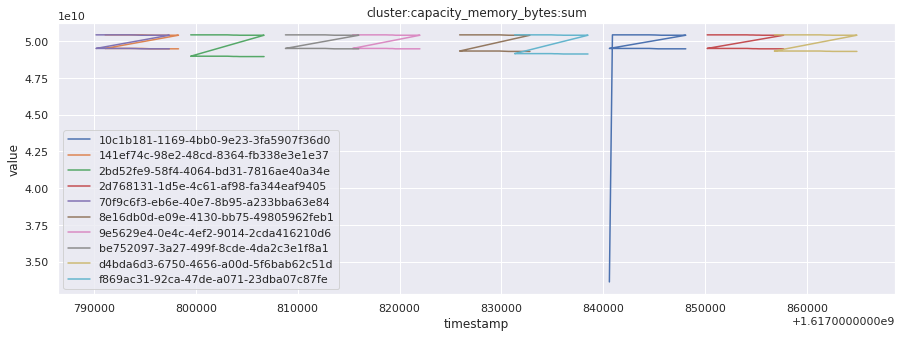

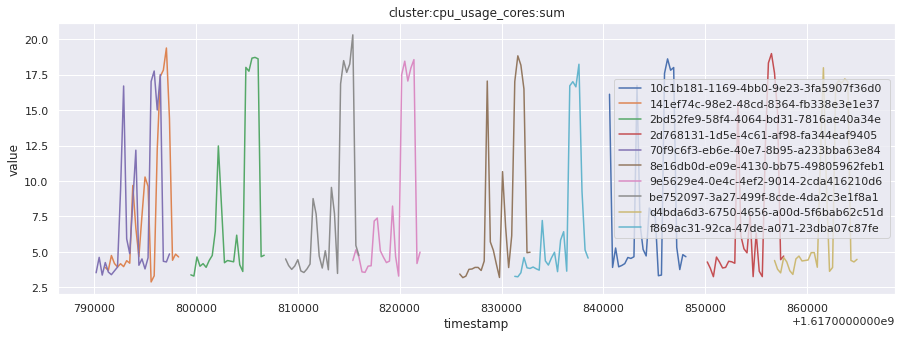

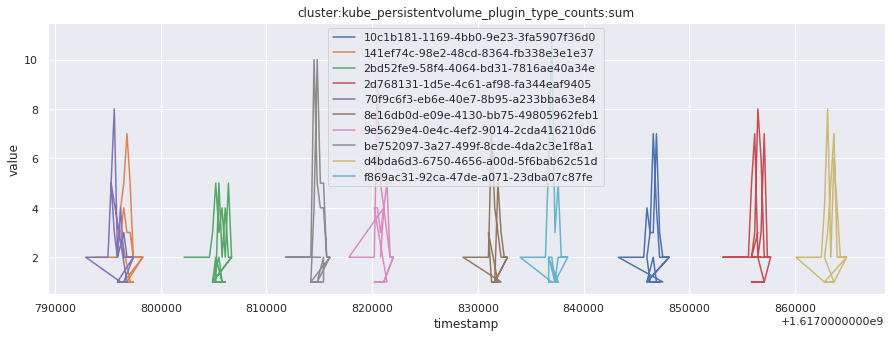

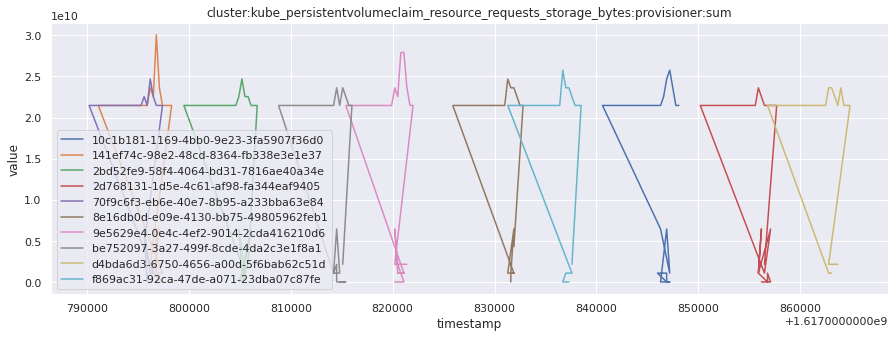

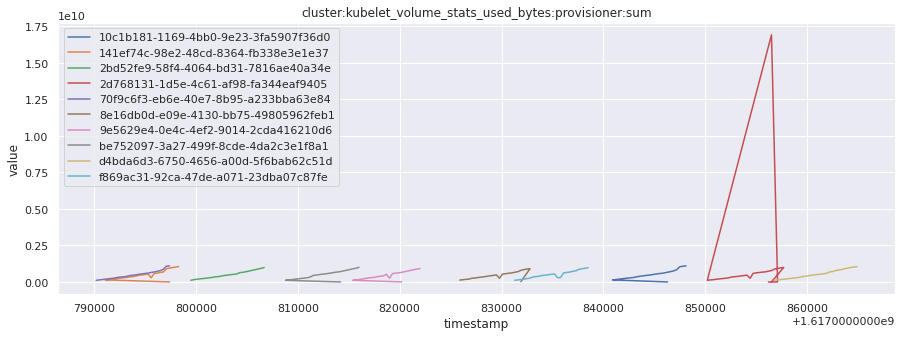

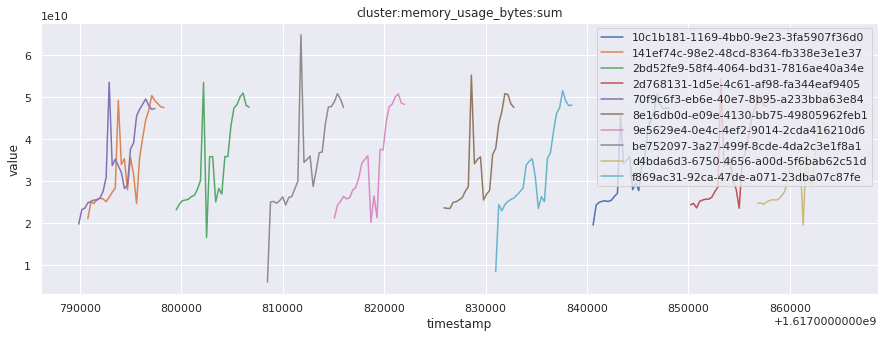

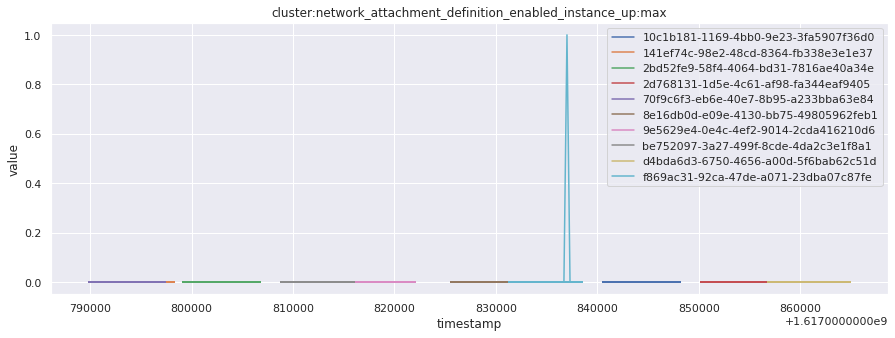

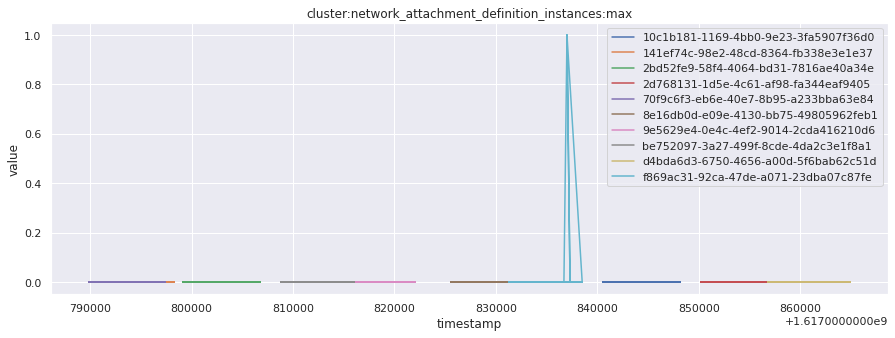

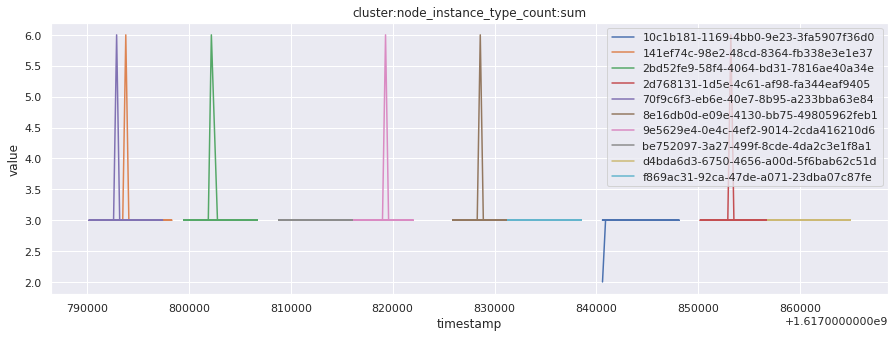

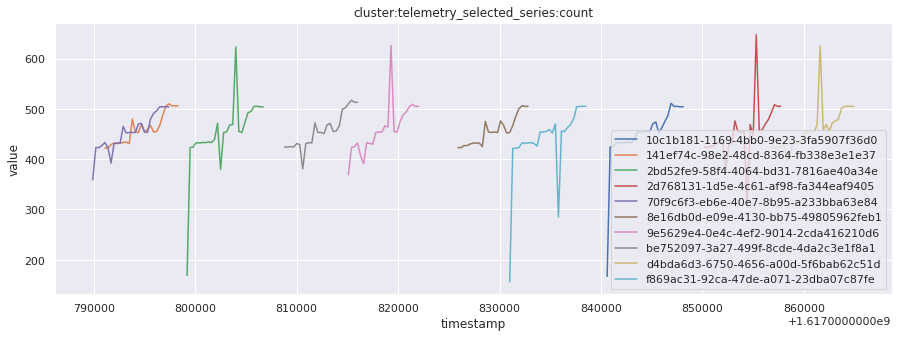

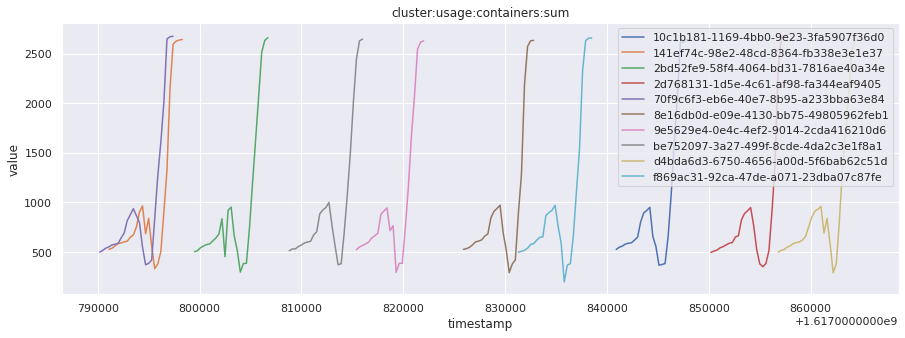

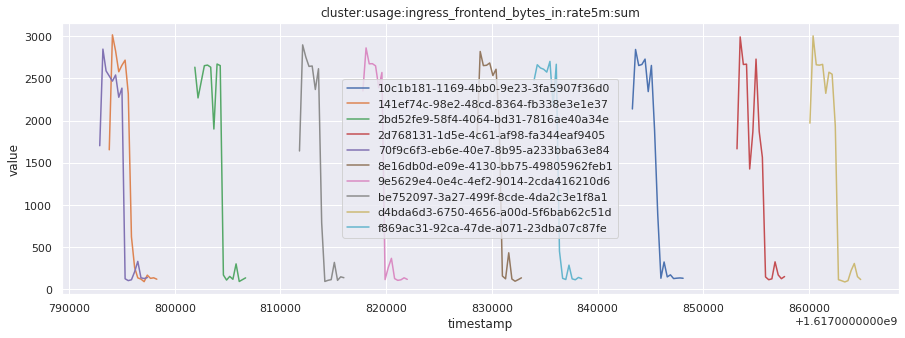

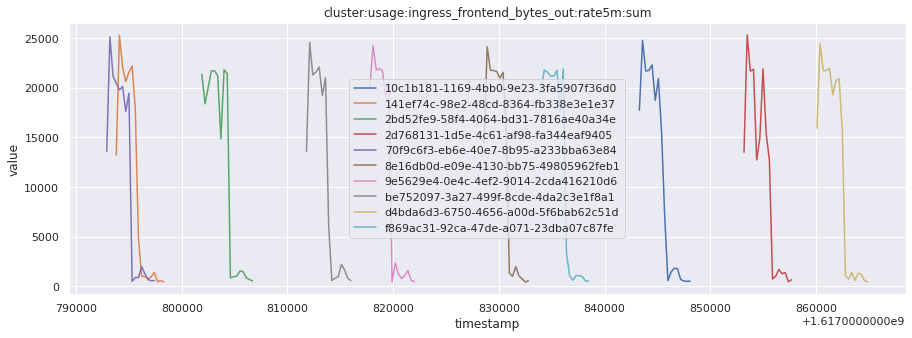

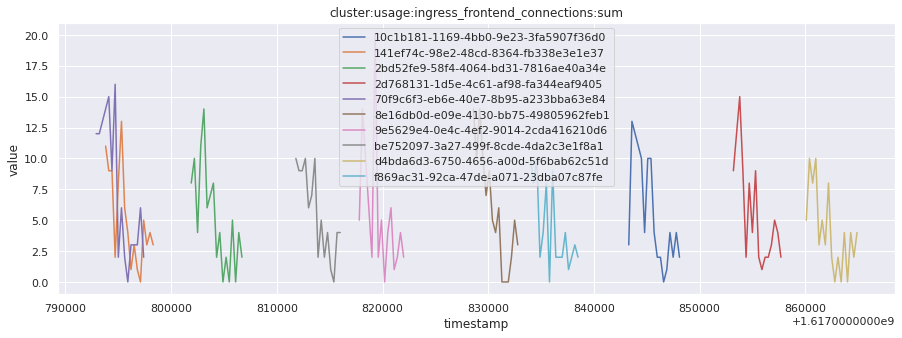

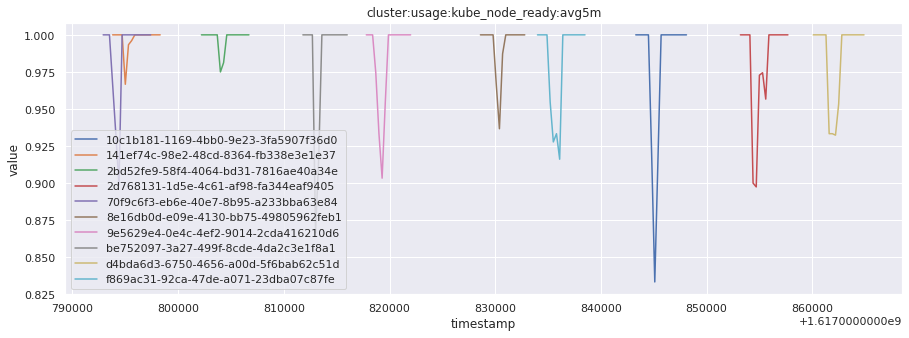

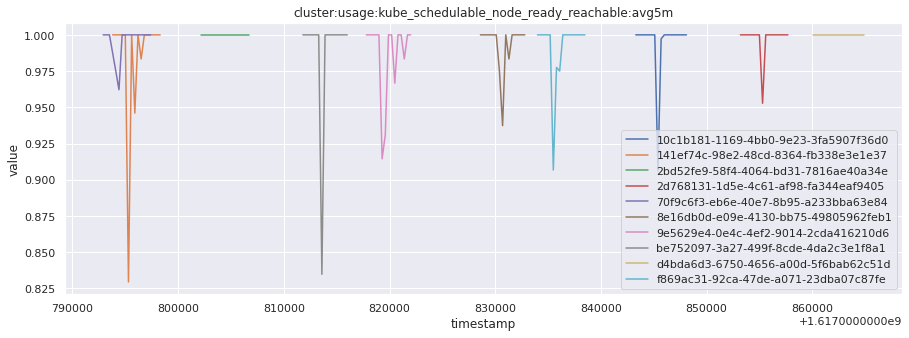

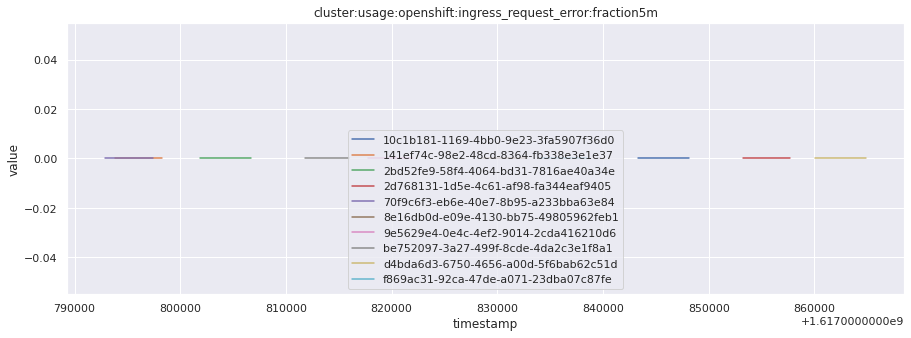

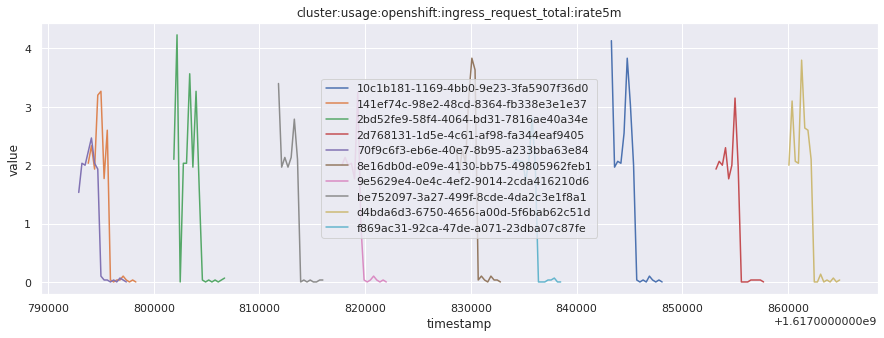

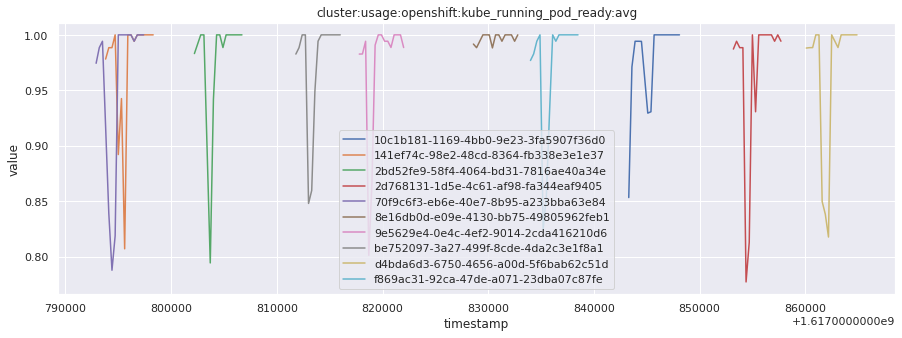

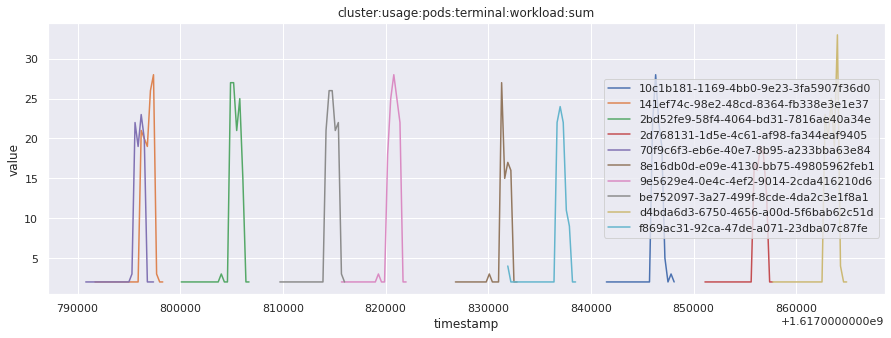

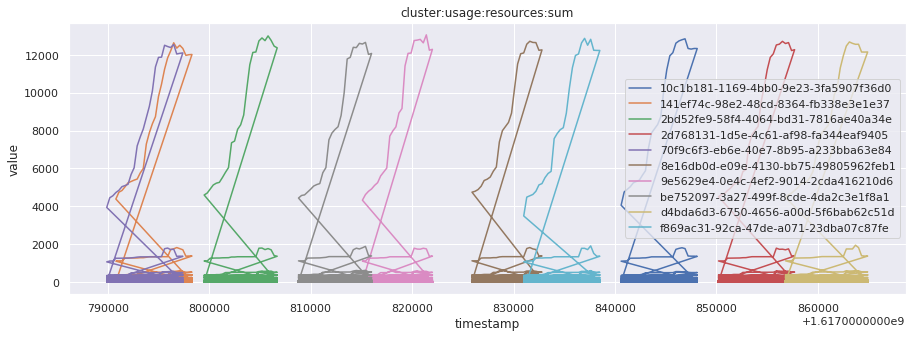

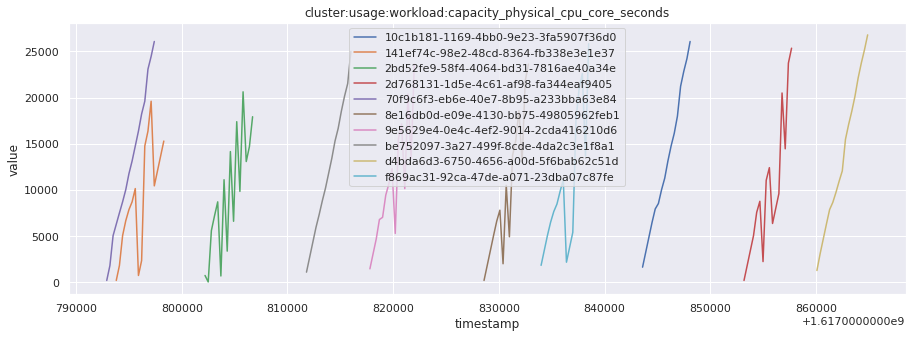

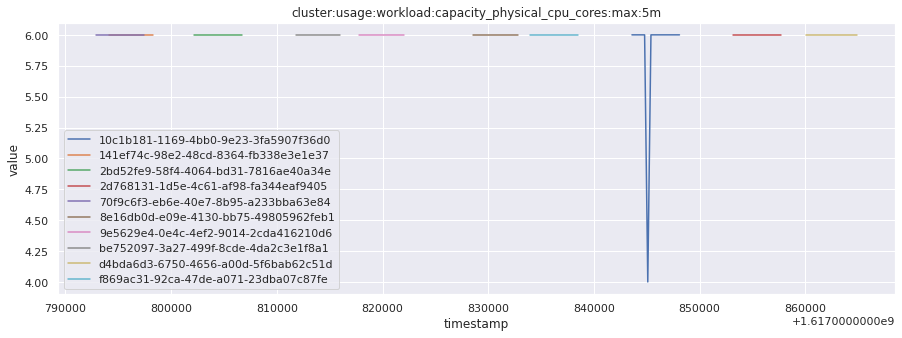

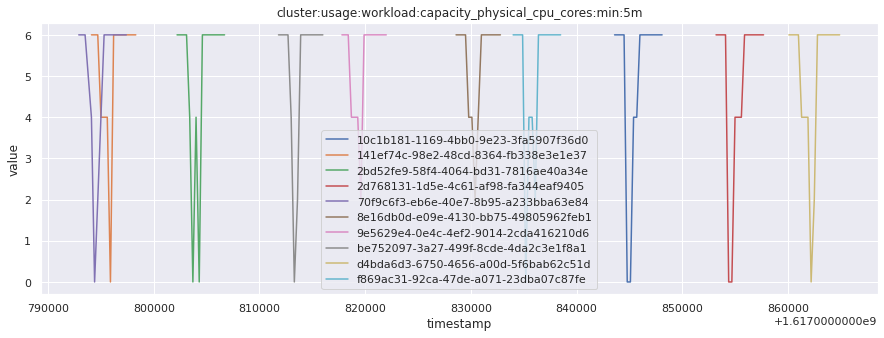

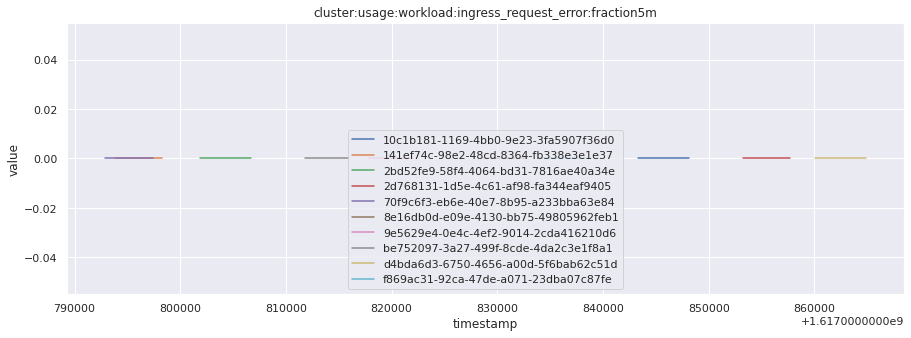

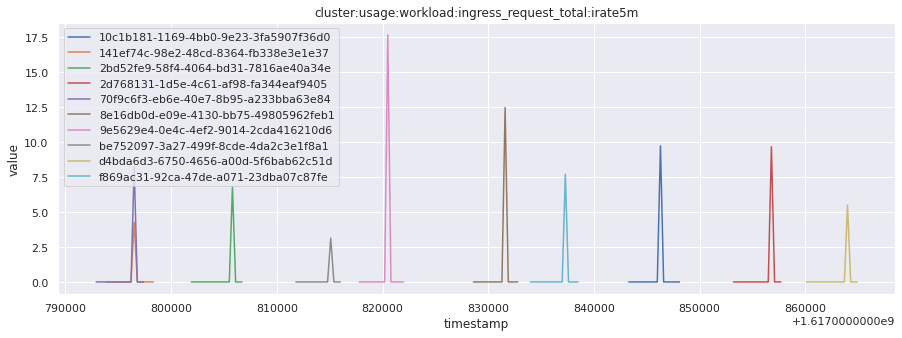

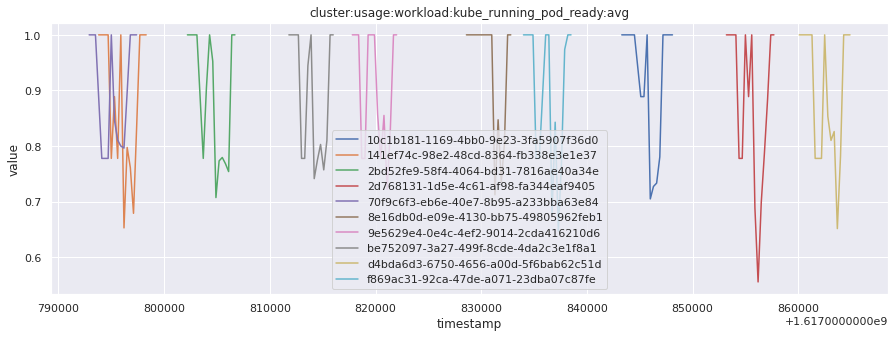

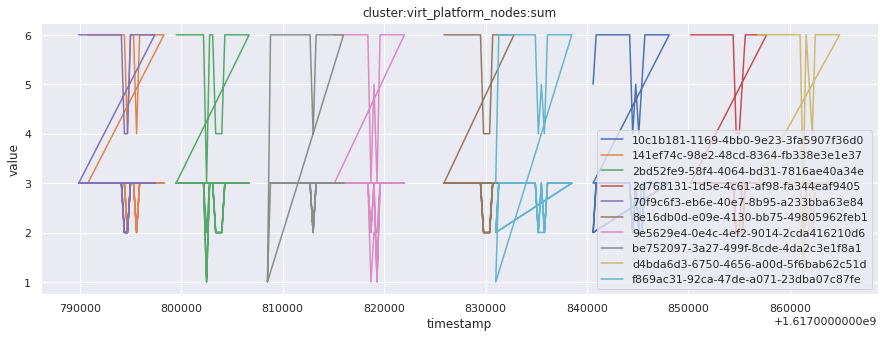

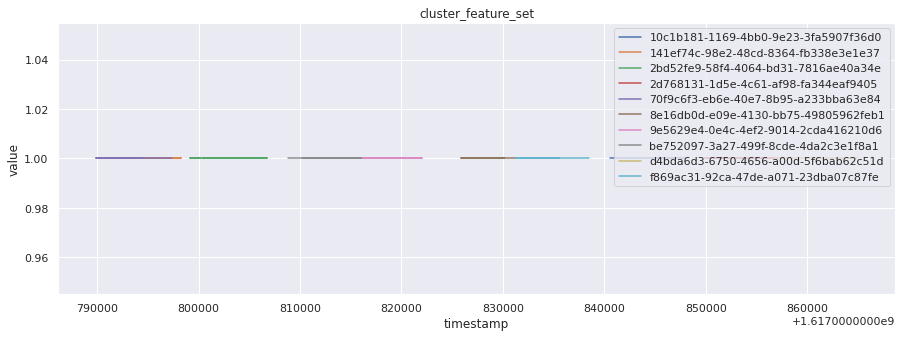

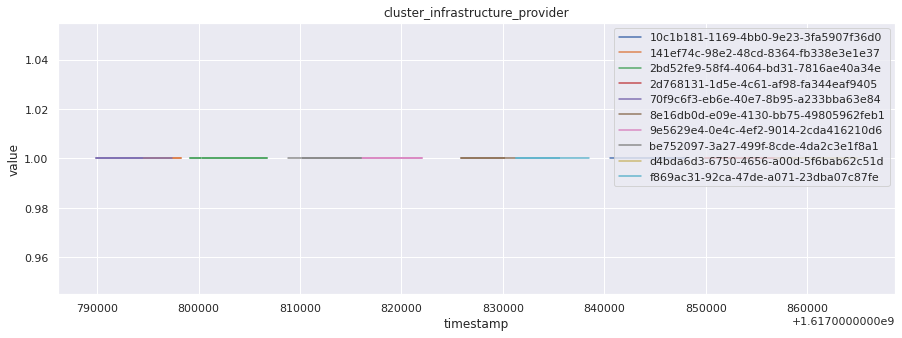

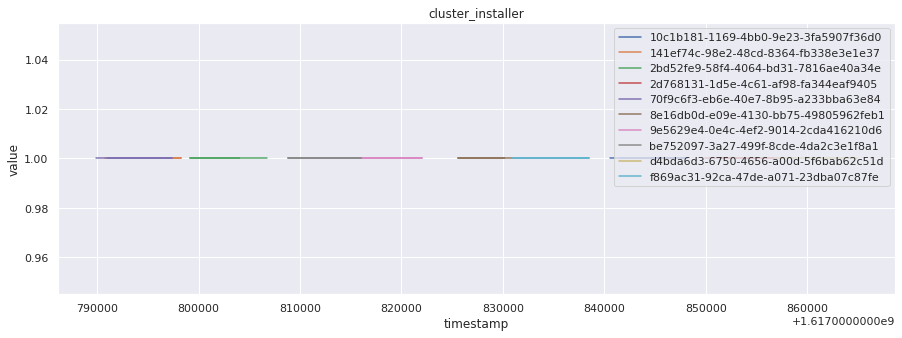

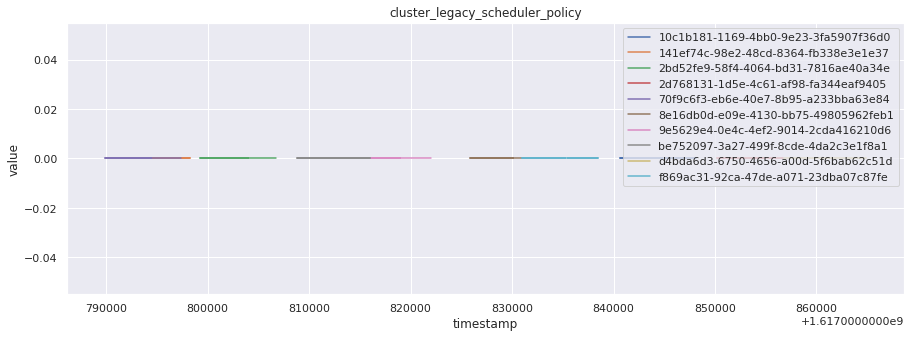

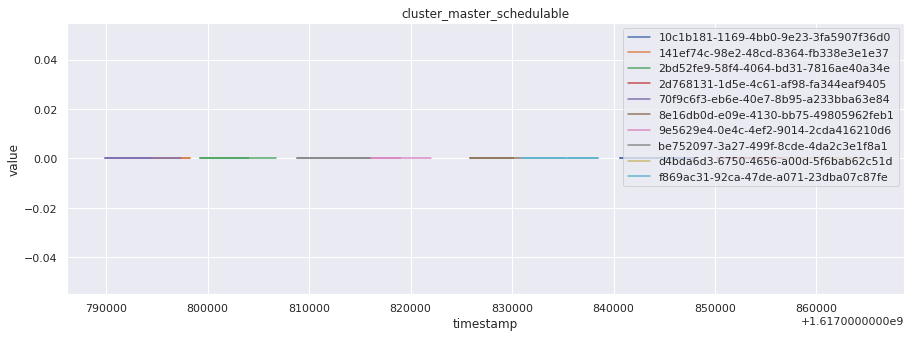

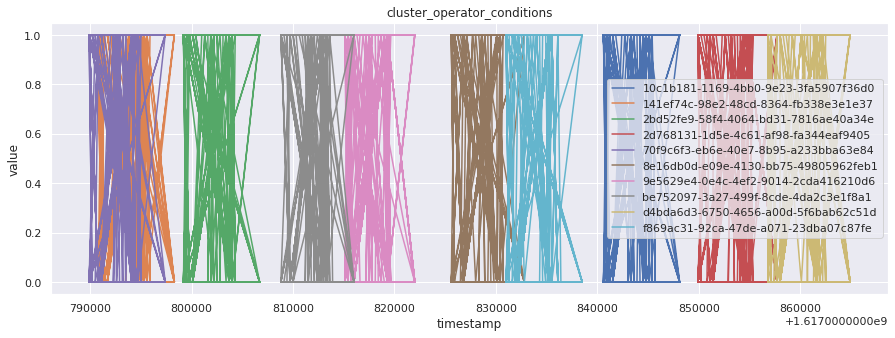

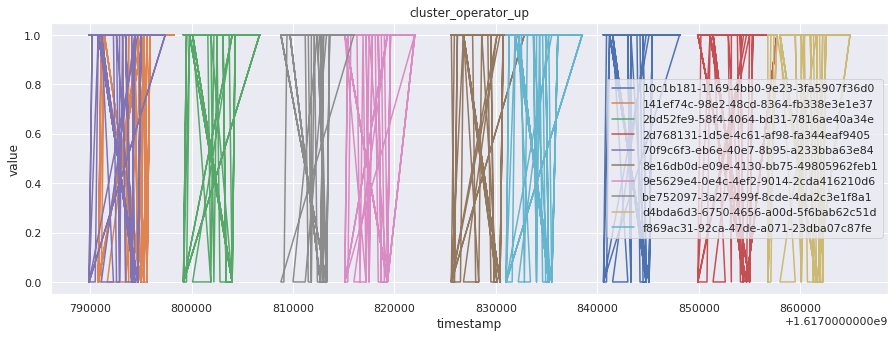

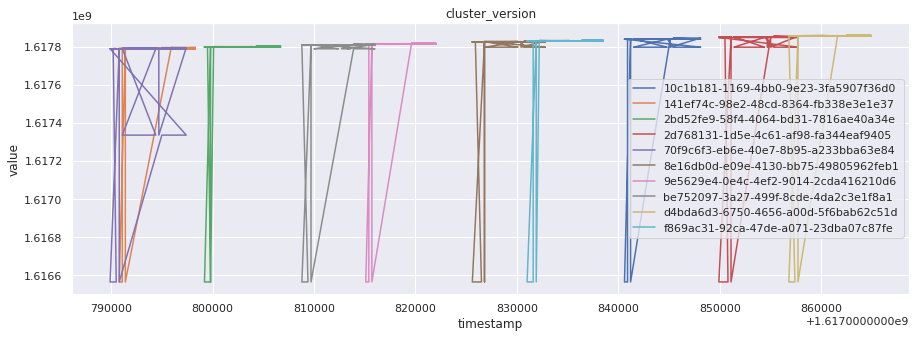

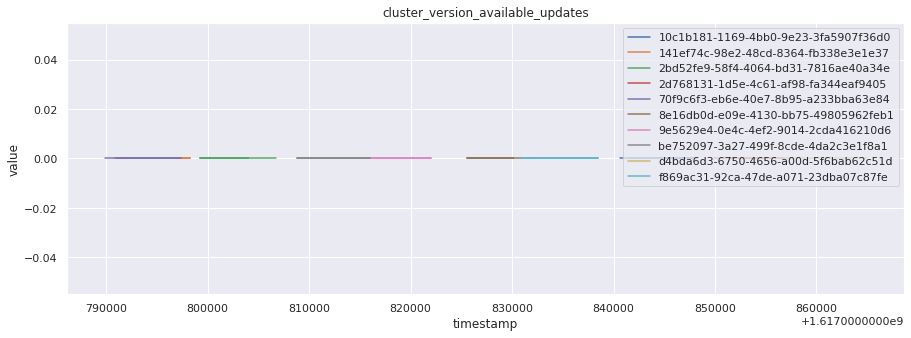

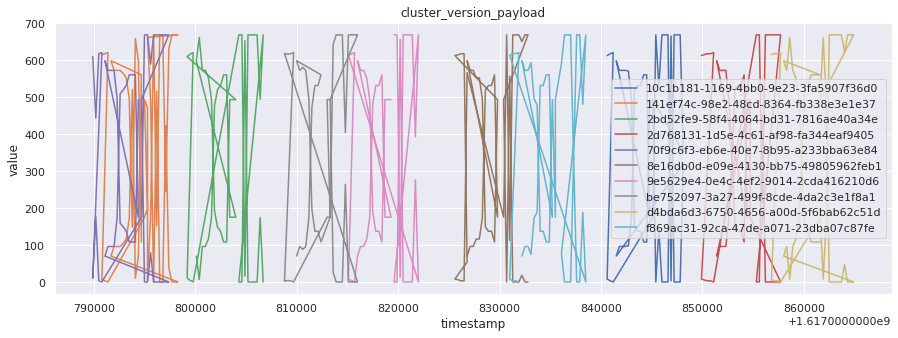

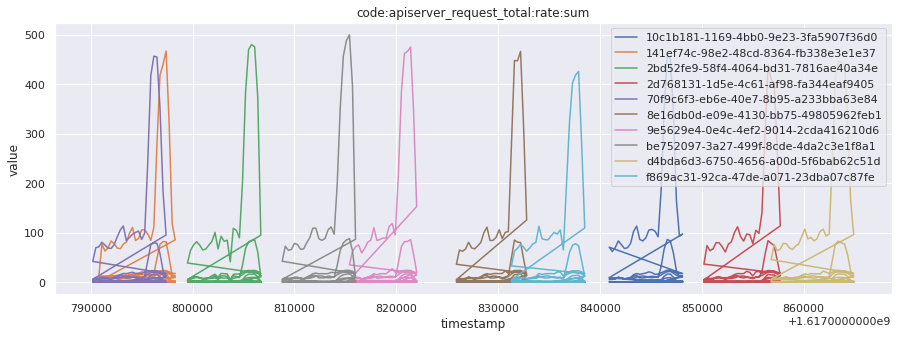

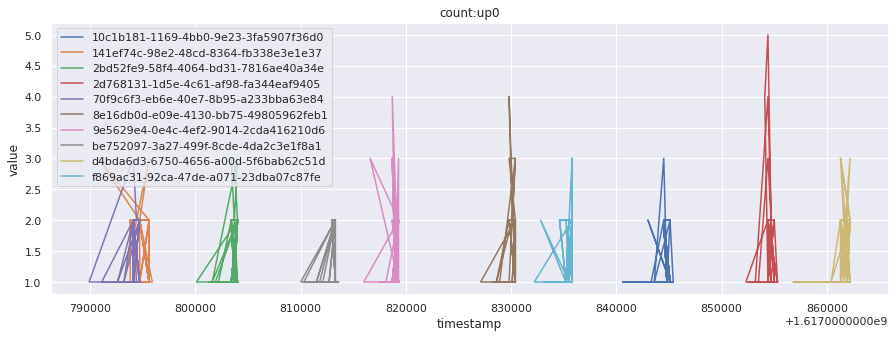

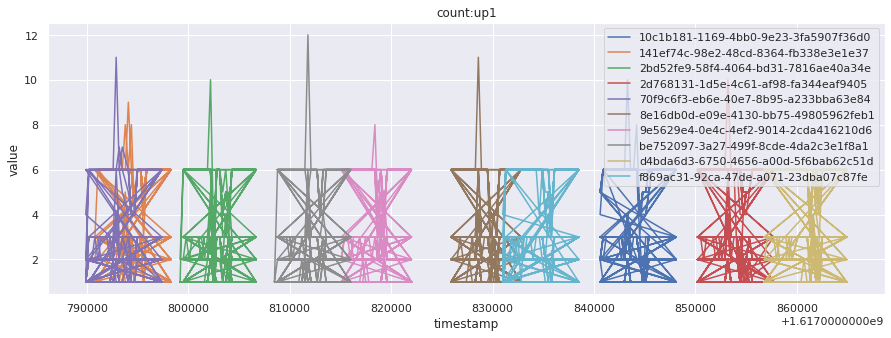

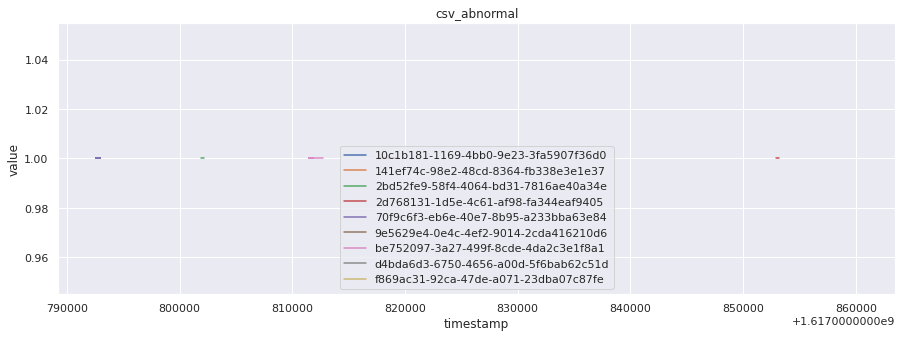

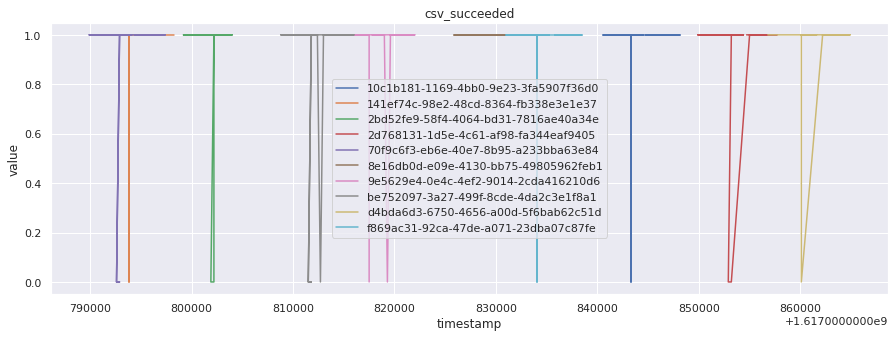

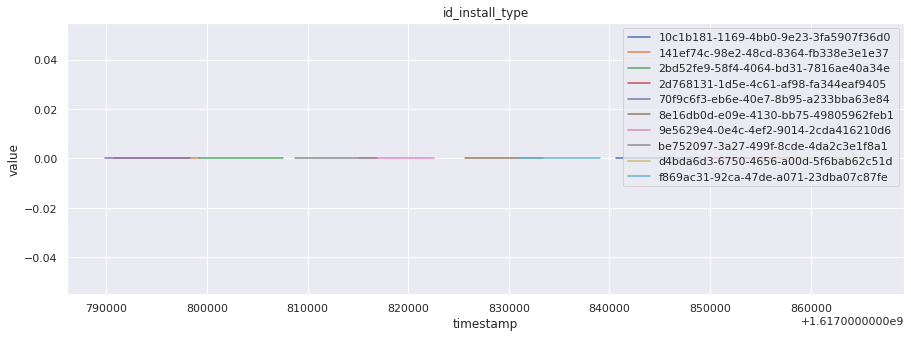

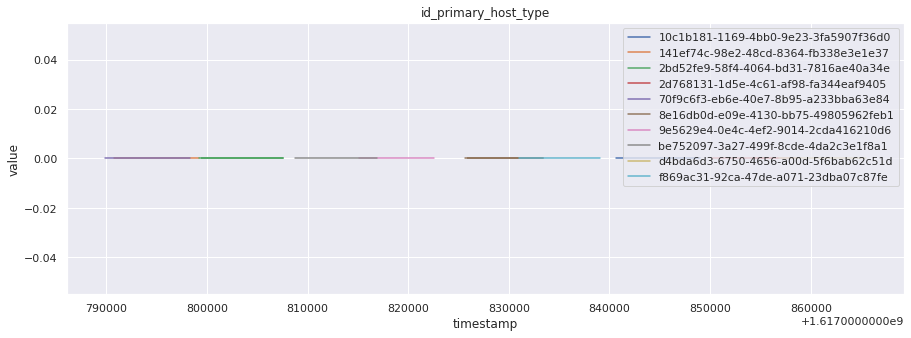

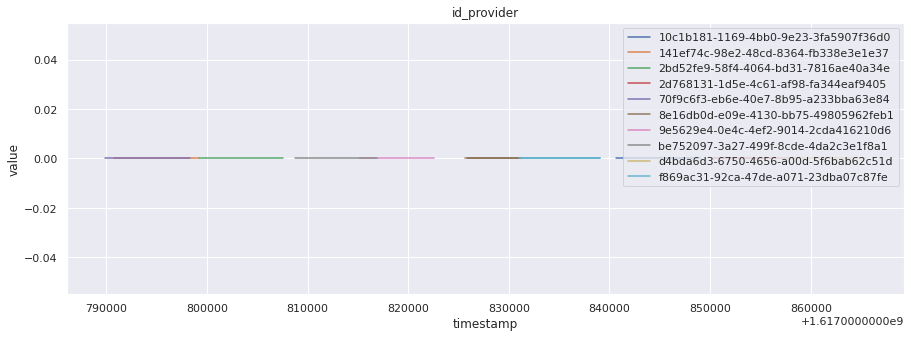

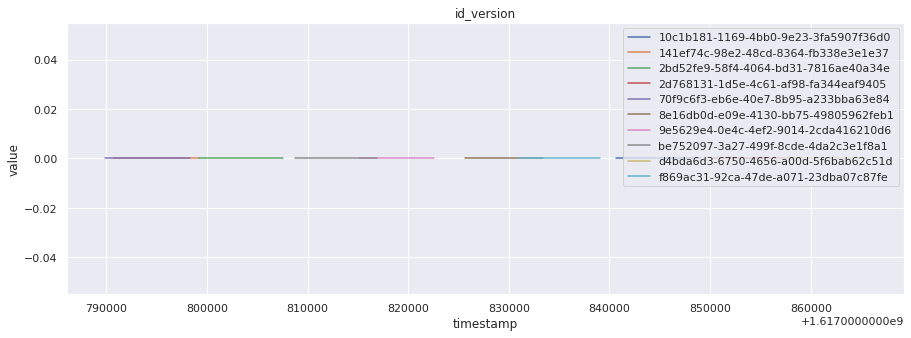

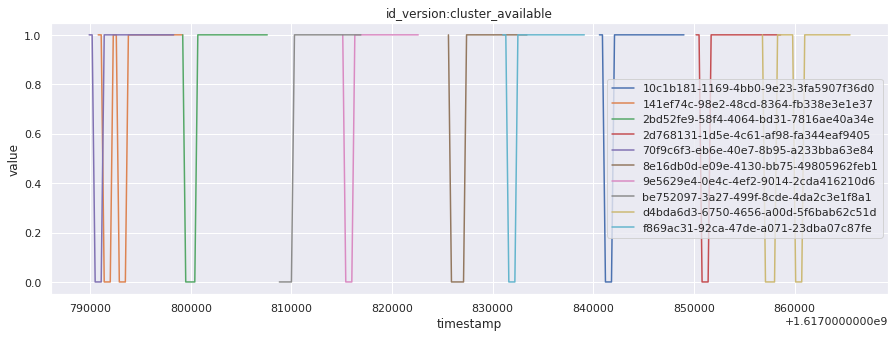

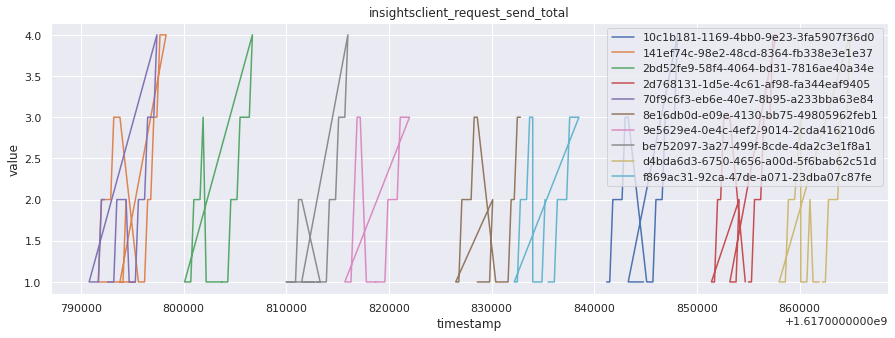

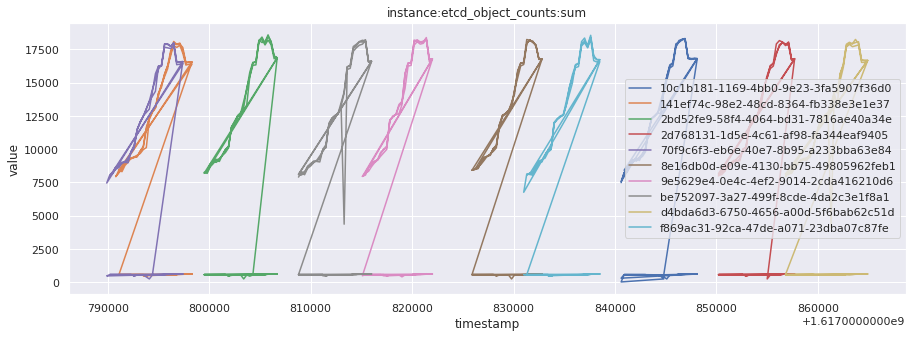

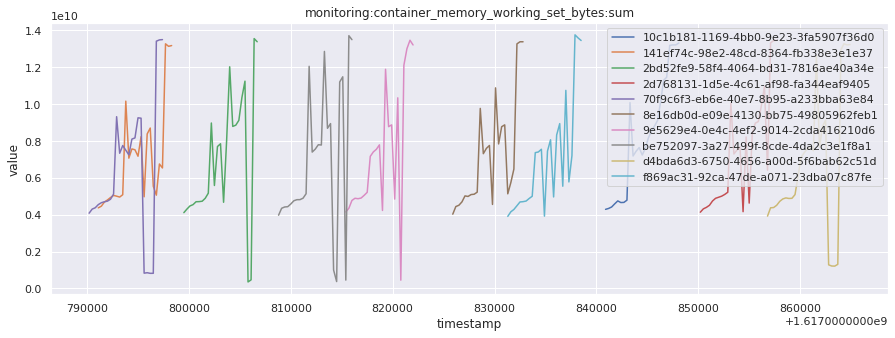

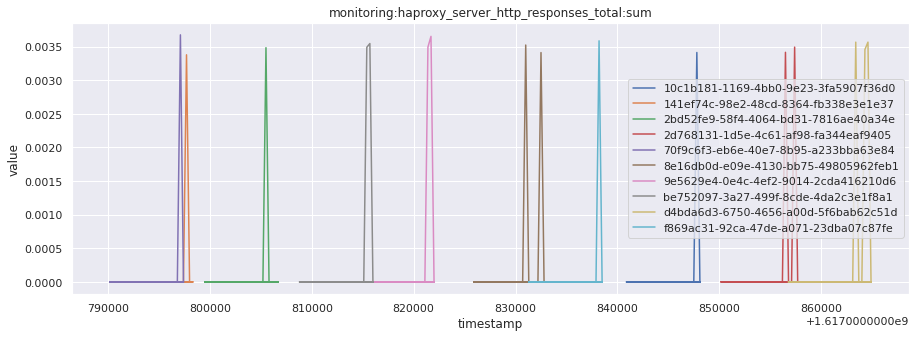

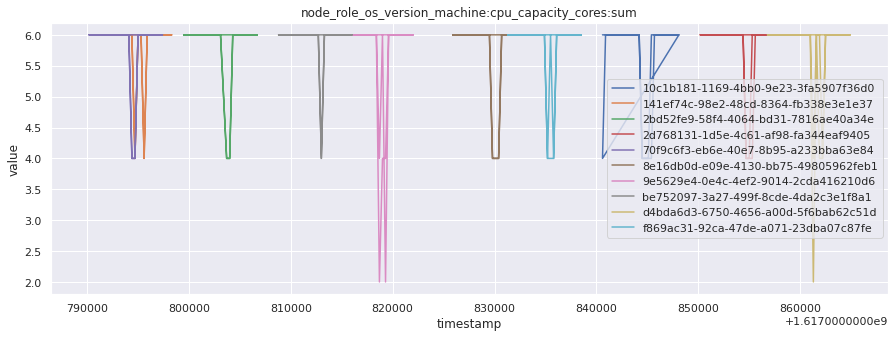

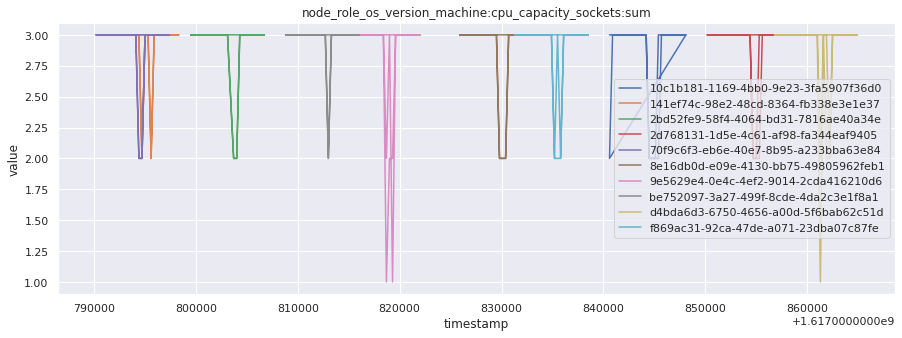

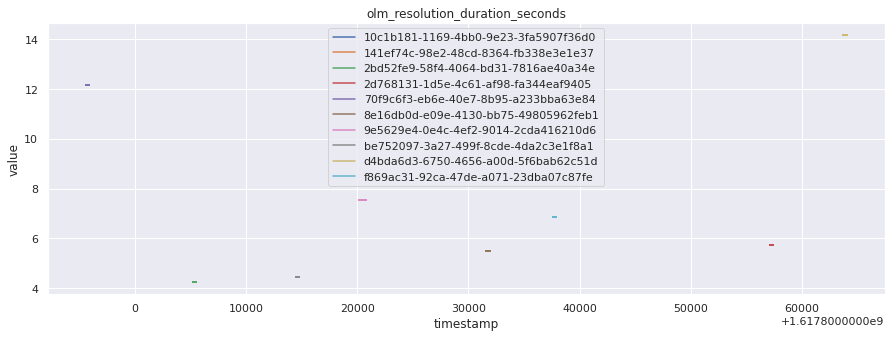

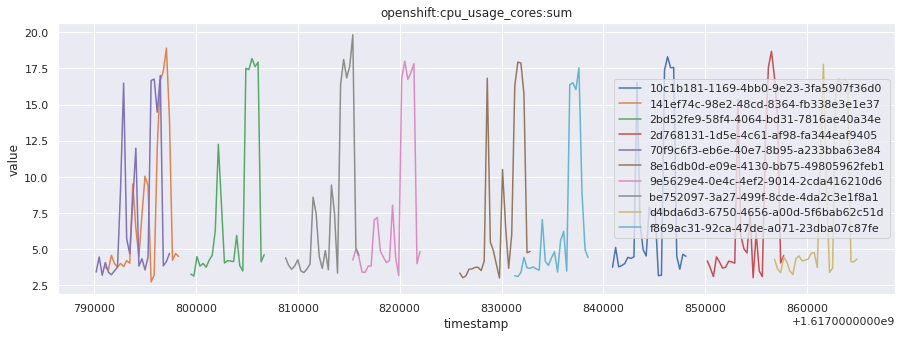

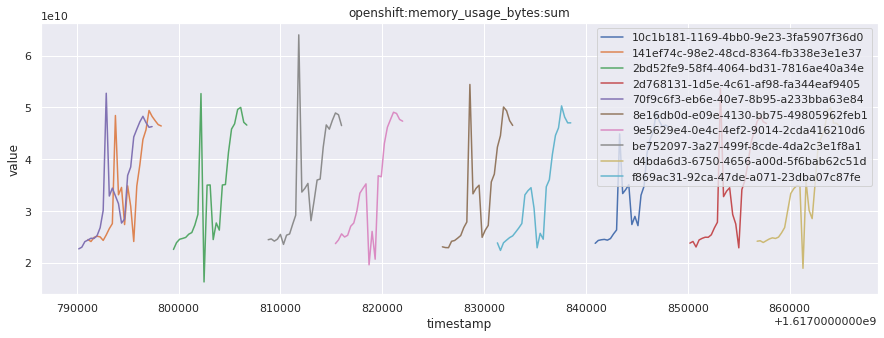

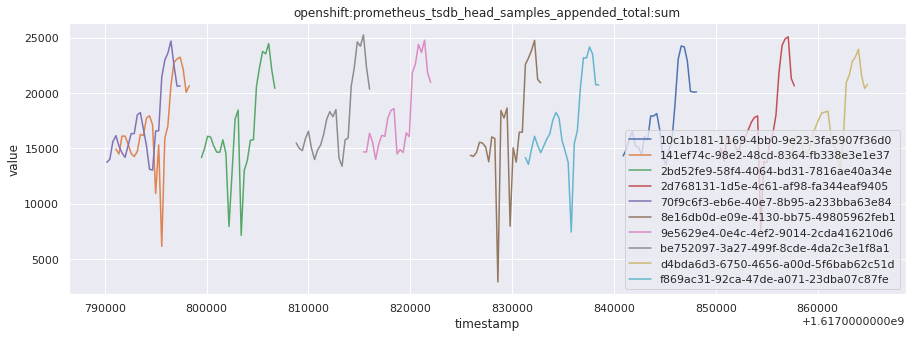

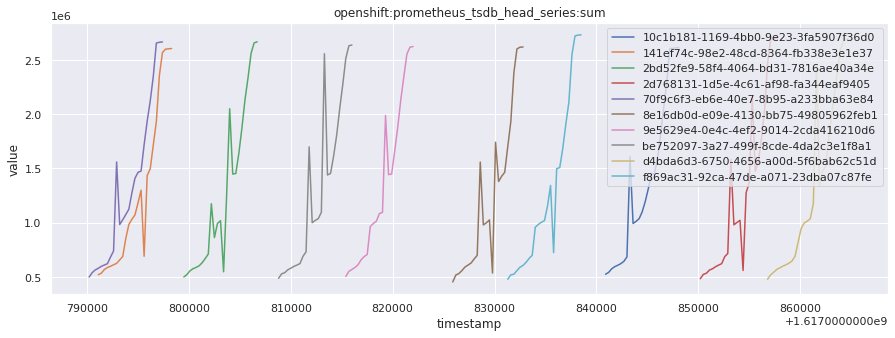

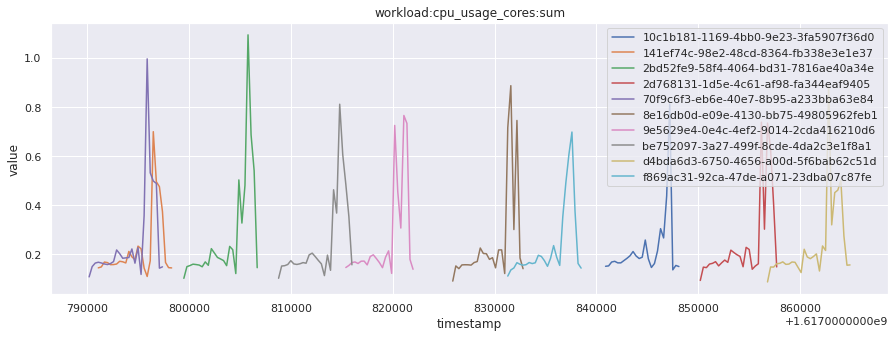

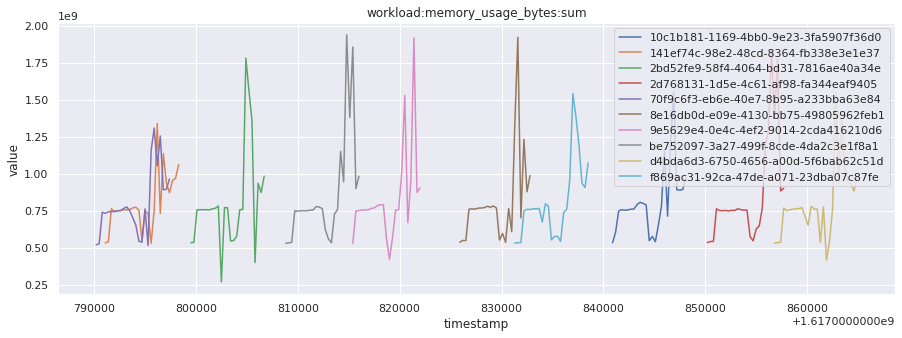

In [26]:
# visualize time series behavior across builds
for metric in all_metrics_df["__name__"].unique():
    plt.figure(figsize=(15, 5))

    metric_df = all_metrics_df[all_metrics_df["__name__"] == metric][
        ["_id", "timestamp", "value"]
    ]
    metric_df.set_index("timestamp").groupby("_id").value.plot(legend=True)

    plt.xlabel("timestamp")
    plt.ylabel("value")
    plt.legend(loc="best")
    plt.title(metric)
    plt.show()

In [36]:
# save the metrics as a static dataset to use in future
save_to_disk(
    all_metrics_df,
    "../../../data/raw/",
    f"telemetry-{query_eval_time.year}-{query_eval_time.month}-{query_eval_time.day}.parquet",
)

True

## Conclusion

In this notebook, we have :
- Collected all telemetry data corresponding to a given job and build.
- Understood how to interpret Prometheus data using an example metric.
- Collected all telemetry data from all timestamps for the top 10 most recent builds for a given job.
- Visualized what the general time series behavior of metrics looks like across builds.
- Saved the above data for further analysis.